# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


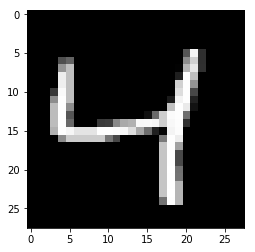

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [4]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation='relu')
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(inputs_, 8, (3,3), padding='same', activation='relu')
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(inputs_, 8, (3,3), padding='same', activation='relu')
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(inputs_, 8, (3,3), padding='same', activation='relu')
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(encoded, (14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(inputs_, 8, (3,3), padding='same', activation='relu')
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(encoded, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation='relu')
# Now 28x28x16

logits = tf.layers.conv2d(inputs_, 1, (3,3), padding='same', activation='relu')
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.


## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [5]:
sess = tf.Session()

In [6]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6820
Epoch: 1/20... Training loss: 0.6823
Epoch: 1/20... Training loss: 0.6826
Epoch: 1/20... Training loss: 0.6817
Epoch: 1/20... Training loss: 0.6820
Epoch: 1/20... Training loss: 0.6811
Epoch: 1/20... Training loss: 0.6816
Epoch: 1/20... Training loss: 0.6822
Epoch: 1/20... Training loss: 0.6814
Epoch: 1/20... Training loss: 0.6802
Epoch: 1/20... Training loss: 0.6808
Epoch: 1/20... Training loss: 0.6817
Epoch: 1/20... Training loss: 0.6796
Epoch: 1/20... Training loss: 0.6793
Epoch: 1/20... Training loss: 0.6804
Epoch: 1/20... Training loss: 0.6797
Epoch: 1/20... Training loss: 0.6801
Epoch: 1/20... Training loss: 0.6792
Epoch: 1/20... Training loss: 0.6803
Epoch: 1/20... Training loss: 0.6787
Epoch: 1/20... Training loss: 0.6803
Epoch: 1/20... Training loss: 0.6795
Epoch: 1/20... Training loss: 0.6784
Epoch: 1/20... Training loss: 0.6794
Epoch: 1/20... Training loss: 0.6787
Epoch: 1/20... Training loss: 0.6775
Epoch: 1/20... Training loss: 0.6785
E

Epoch: 1/20... Training loss: 0.6648
Epoch: 1/20... Training loss: 0.6625
Epoch: 1/20... Training loss: 0.6625
Epoch: 1/20... Training loss: 0.6630
Epoch: 1/20... Training loss: 0.6635
Epoch: 1/20... Training loss: 0.6616
Epoch: 1/20... Training loss: 0.6626
Epoch: 1/20... Training loss: 0.6645
Epoch: 1/20... Training loss: 0.6640
Epoch: 1/20... Training loss: 0.6644
Epoch: 1/20... Training loss: 0.6630
Epoch: 1/20... Training loss: 0.6619
Epoch: 1/20... Training loss: 0.6638
Epoch: 1/20... Training loss: 0.6628
Epoch: 1/20... Training loss: 0.6630
Epoch: 1/20... Training loss: 0.6633
Epoch: 1/20... Training loss: 0.6625
Epoch: 1/20... Training loss: 0.6632
Epoch: 1/20... Training loss: 0.6635
Epoch: 1/20... Training loss: 0.6634
Epoch: 1/20... Training loss: 0.6627
Epoch: 1/20... Training loss: 0.6631
Epoch: 1/20... Training loss: 0.6606
Epoch: 1/20... Training loss: 0.6638
Epoch: 1/20... Training loss: 0.6612
Epoch: 1/20... Training loss: 0.6621
Epoch: 1/20... Training loss: 0.6631
E

Epoch: 2/20... Training loss: 0.6575
Epoch: 2/20... Training loss: 0.6550
Epoch: 2/20... Training loss: 0.6552
Epoch: 2/20... Training loss: 0.6541
Epoch: 2/20... Training loss: 0.6547
Epoch: 2/20... Training loss: 0.6533
Epoch: 2/20... Training loss: 0.6564
Epoch: 2/20... Training loss: 0.6535
Epoch: 2/20... Training loss: 0.6544
Epoch: 2/20... Training loss: 0.6540
Epoch: 2/20... Training loss: 0.6564
Epoch: 2/20... Training loss: 0.6555
Epoch: 2/20... Training loss: 0.6557
Epoch: 2/20... Training loss: 0.6558
Epoch: 2/20... Training loss: 0.6554
Epoch: 2/20... Training loss: 0.6543
Epoch: 2/20... Training loss: 0.6552
Epoch: 2/20... Training loss: 0.6570
Epoch: 2/20... Training loss: 0.6556
Epoch: 2/20... Training loss: 0.6547
Epoch: 2/20... Training loss: 0.6555
Epoch: 2/20... Training loss: 0.6539
Epoch: 2/20... Training loss: 0.6569
Epoch: 2/20... Training loss: 0.6554
Epoch: 2/20... Training loss: 0.6530
Epoch: 2/20... Training loss: 0.6556
Epoch: 2/20... Training loss: 0.6545
E

Epoch: 3/20... Training loss: 0.6522
Epoch: 3/20... Training loss: 0.6504
Epoch: 3/20... Training loss: 0.6504
Epoch: 3/20... Training loss: 0.6501
Epoch: 3/20... Training loss: 0.6519
Epoch: 3/20... Training loss: 0.6508
Epoch: 3/20... Training loss: 0.6512
Epoch: 3/20... Training loss: 0.6518
Epoch: 3/20... Training loss: 0.6527
Epoch: 3/20... Training loss: 0.6489
Epoch: 3/20... Training loss: 0.6520
Epoch: 3/20... Training loss: 0.6506
Epoch: 3/20... Training loss: 0.6533
Epoch: 3/20... Training loss: 0.6508
Epoch: 3/20... Training loss: 0.6484
Epoch: 3/20... Training loss: 0.6492
Epoch: 3/20... Training loss: 0.6503
Epoch: 3/20... Training loss: 0.6520
Epoch: 3/20... Training loss: 0.6512
Epoch: 3/20... Training loss: 0.6497
Epoch: 3/20... Training loss: 0.6500
Epoch: 3/20... Training loss: 0.6492
Epoch: 3/20... Training loss: 0.6514
Epoch: 3/20... Training loss: 0.6507
Epoch: 3/20... Training loss: 0.6491
Epoch: 3/20... Training loss: 0.6498
Epoch: 3/20... Training loss: 0.6503
E

Epoch: 4/20... Training loss: 0.6469
Epoch: 4/20... Training loss: 0.6472
Epoch: 4/20... Training loss: 0.6464
Epoch: 4/20... Training loss: 0.6456
Epoch: 4/20... Training loss: 0.6524
Epoch: 4/20... Training loss: 0.6466
Epoch: 4/20... Training loss: 0.6494
Epoch: 4/20... Training loss: 0.6490
Epoch: 4/20... Training loss: 0.6483
Epoch: 4/20... Training loss: 0.6468
Epoch: 4/20... Training loss: 0.6480
Epoch: 4/20... Training loss: 0.6505
Epoch: 4/20... Training loss: 0.6465
Epoch: 4/20... Training loss: 0.6476
Epoch: 4/20... Training loss: 0.6477
Epoch: 4/20... Training loss: 0.6452
Epoch: 4/20... Training loss: 0.6486
Epoch: 4/20... Training loss: 0.6468
Epoch: 4/20... Training loss: 0.6484
Epoch: 4/20... Training loss: 0.6500
Epoch: 4/20... Training loss: 0.6459
Epoch: 4/20... Training loss: 0.6490
Epoch: 4/20... Training loss: 0.6500
Epoch: 4/20... Training loss: 0.6507
Epoch: 4/20... Training loss: 0.6466
Epoch: 4/20... Training loss: 0.6459
Epoch: 4/20... Training loss: 0.6472
E

Epoch: 4/20... Training loss: 0.6451
Epoch: 4/20... Training loss: 0.6459
Epoch: 4/20... Training loss: 0.6447
Epoch: 4/20... Training loss: 0.6470
Epoch: 4/20... Training loss: 0.6426
Epoch: 4/20... Training loss: 0.6471
Epoch: 4/20... Training loss: 0.6480
Epoch: 4/20... Training loss: 0.6462
Epoch: 4/20... Training loss: 0.6478
Epoch: 4/20... Training loss: 0.6447
Epoch: 4/20... Training loss: 0.6498
Epoch: 4/20... Training loss: 0.6473
Epoch: 4/20... Training loss: 0.6468
Epoch: 4/20... Training loss: 0.6485
Epoch: 4/20... Training loss: 0.6488
Epoch: 4/20... Training loss: 0.6466
Epoch: 4/20... Training loss: 0.6471
Epoch: 4/20... Training loss: 0.6473
Epoch: 4/20... Training loss: 0.6486
Epoch: 4/20... Training loss: 0.6463
Epoch: 4/20... Training loss: 0.6473
Epoch: 4/20... Training loss: 0.6437
Epoch: 5/20... Training loss: 0.6479
Epoch: 5/20... Training loss: 0.6486
Epoch: 5/20... Training loss: 0.6452
Epoch: 5/20... Training loss: 0.6478
Epoch: 5/20... Training loss: 0.6456
E

Epoch: 5/20... Training loss: 0.6466
Epoch: 5/20... Training loss: 0.6478
Epoch: 5/20... Training loss: 0.6432
Epoch: 5/20... Training loss: 0.6481
Epoch: 5/20... Training loss: 0.6446
Epoch: 5/20... Training loss: 0.6407
Epoch: 5/20... Training loss: 0.6457
Epoch: 5/20... Training loss: 0.6435
Epoch: 5/20... Training loss: 0.6456
Epoch: 5/20... Training loss: 0.6455
Epoch: 5/20... Training loss: 0.6456
Epoch: 5/20... Training loss: 0.6460
Epoch: 5/20... Training loss: 0.6466
Epoch: 5/20... Training loss: 0.6462
Epoch: 5/20... Training loss: 0.6461
Epoch: 5/20... Training loss: 0.6460
Epoch: 5/20... Training loss: 0.6425
Epoch: 5/20... Training loss: 0.6473
Epoch: 5/20... Training loss: 0.6457
Epoch: 5/20... Training loss: 0.6432
Epoch: 5/20... Training loss: 0.6468
Epoch: 5/20... Training loss: 0.6442
Epoch: 5/20... Training loss: 0.6461
Epoch: 5/20... Training loss: 0.6434
Epoch: 5/20... Training loss: 0.6455
Epoch: 5/20... Training loss: 0.6397
Epoch: 5/20... Training loss: 0.6456
E

Epoch: 6/20... Training loss: 0.6428
Epoch: 6/20... Training loss: 0.6409
Epoch: 6/20... Training loss: 0.6441
Epoch: 6/20... Training loss: 0.6416
Epoch: 6/20... Training loss: 0.6429
Epoch: 6/20... Training loss: 0.6445
Epoch: 6/20... Training loss: 0.6436
Epoch: 6/20... Training loss: 0.6426
Epoch: 6/20... Training loss: 0.6415
Epoch: 6/20... Training loss: 0.6445
Epoch: 6/20... Training loss: 0.6414
Epoch: 6/20... Training loss: 0.6439
Epoch: 6/20... Training loss: 0.6440
Epoch: 6/20... Training loss: 0.6398
Epoch: 6/20... Training loss: 0.6444
Epoch: 6/20... Training loss: 0.6414
Epoch: 6/20... Training loss: 0.6452
Epoch: 6/20... Training loss: 0.6451
Epoch: 6/20... Training loss: 0.6432
Epoch: 6/20... Training loss: 0.6422
Epoch: 6/20... Training loss: 0.6443
Epoch: 6/20... Training loss: 0.6421
Epoch: 6/20... Training loss: 0.6432
Epoch: 6/20... Training loss: 0.6425
Epoch: 6/20... Training loss: 0.6455
Epoch: 6/20... Training loss: 0.6442
Epoch: 6/20... Training loss: 0.6430
E

Epoch: 7/20... Training loss: 0.6423
Epoch: 7/20... Training loss: 0.6434
Epoch: 7/20... Training loss: 0.6420
Epoch: 7/20... Training loss: 0.6416
Epoch: 7/20... Training loss: 0.6428
Epoch: 7/20... Training loss: 0.6408
Epoch: 7/20... Training loss: 0.6424
Epoch: 7/20... Training loss: 0.6460
Epoch: 7/20... Training loss: 0.6429
Epoch: 7/20... Training loss: 0.6433
Epoch: 7/20... Training loss: 0.6417
Epoch: 7/20... Training loss: 0.6447
Epoch: 7/20... Training loss: 0.6420
Epoch: 7/20... Training loss: 0.6428
Epoch: 7/20... Training loss: 0.6417
Epoch: 7/20... Training loss: 0.6421
Epoch: 7/20... Training loss: 0.6428
Epoch: 7/20... Training loss: 0.6418
Epoch: 7/20... Training loss: 0.6415
Epoch: 7/20... Training loss: 0.6419
Epoch: 7/20... Training loss: 0.6445
Epoch: 7/20... Training loss: 0.6407
Epoch: 7/20... Training loss: 0.6417
Epoch: 7/20... Training loss: 0.6438
Epoch: 7/20... Training loss: 0.6408
Epoch: 7/20... Training loss: 0.6439
Epoch: 7/20... Training loss: 0.6450
E

Epoch: 8/20... Training loss: 0.6416
Epoch: 8/20... Training loss: 0.6411
Epoch: 8/20... Training loss: 0.6433
Epoch: 8/20... Training loss: 0.6428
Epoch: 8/20... Training loss: 0.6431
Epoch: 8/20... Training loss: 0.6419
Epoch: 8/20... Training loss: 0.6418
Epoch: 8/20... Training loss: 0.6419
Epoch: 8/20... Training loss: 0.6433
Epoch: 8/20... Training loss: 0.6400
Epoch: 8/20... Training loss: 0.6395
Epoch: 8/20... Training loss: 0.6403
Epoch: 8/20... Training loss: 0.6397
Epoch: 8/20... Training loss: 0.6398
Epoch: 8/20... Training loss: 0.6459
Epoch: 8/20... Training loss: 0.6413
Epoch: 8/20... Training loss: 0.6394
Epoch: 8/20... Training loss: 0.6407
Epoch: 8/20... Training loss: 0.6421
Epoch: 8/20... Training loss: 0.6401
Epoch: 8/20... Training loss: 0.6425
Epoch: 8/20... Training loss: 0.6406
Epoch: 8/20... Training loss: 0.6429
Epoch: 8/20... Training loss: 0.6418
Epoch: 8/20... Training loss: 0.6415
Epoch: 8/20... Training loss: 0.6447
Epoch: 8/20... Training loss: 0.6434
E

Epoch: 8/20... Training loss: 0.6421
Epoch: 8/20... Training loss: 0.6401
Epoch: 8/20... Training loss: 0.6428
Epoch: 8/20... Training loss: 0.6424
Epoch: 8/20... Training loss: 0.6423
Epoch: 8/20... Training loss: 0.6382
Epoch: 8/20... Training loss: 0.6399
Epoch: 8/20... Training loss: 0.6412
Epoch: 8/20... Training loss: 0.6414
Epoch: 8/20... Training loss: 0.6403
Epoch: 8/20... Training loss: 0.6429
Epoch: 8/20... Training loss: 0.6424
Epoch: 8/20... Training loss: 0.6387
Epoch: 8/20... Training loss: 0.6406
Epoch: 8/20... Training loss: 0.6411
Epoch: 8/20... Training loss: 0.6410
Epoch: 8/20... Training loss: 0.6399
Epoch: 8/20... Training loss: 0.6392
Epoch: 8/20... Training loss: 0.6432
Epoch: 8/20... Training loss: 0.6380
Epoch: 8/20... Training loss: 0.6427
Epoch: 8/20... Training loss: 0.6409
Epoch: 8/20... Training loss: 0.6419
Epoch: 8/20... Training loss: 0.6409
Epoch: 8/20... Training loss: 0.6387
Epoch: 8/20... Training loss: 0.6426
Epoch: 8/20... Training loss: 0.6388
E

Epoch: 9/20... Training loss: 0.6393
Epoch: 9/20... Training loss: 0.6415
Epoch: 9/20... Training loss: 0.6415
Epoch: 9/20... Training loss: 0.6426
Epoch: 9/20... Training loss: 0.6376
Epoch: 9/20... Training loss: 0.6427
Epoch: 9/20... Training loss: 0.6410
Epoch: 9/20... Training loss: 0.6405
Epoch: 9/20... Training loss: 0.6397
Epoch: 9/20... Training loss: 0.6409
Epoch: 9/20... Training loss: 0.6406
Epoch: 9/20... Training loss: 0.6393
Epoch: 9/20... Training loss: 0.6390
Epoch: 9/20... Training loss: 0.6402
Epoch: 9/20... Training loss: 0.6399
Epoch: 9/20... Training loss: 0.6407
Epoch: 9/20... Training loss: 0.6419
Epoch: 9/20... Training loss: 0.6400
Epoch: 9/20... Training loss: 0.6422
Epoch: 9/20... Training loss: 0.6380
Epoch: 9/20... Training loss: 0.6397
Epoch: 9/20... Training loss: 0.6399
Epoch: 9/20... Training loss: 0.6395
Epoch: 9/20... Training loss: 0.6416
Epoch: 9/20... Training loss: 0.6398
Epoch: 9/20... Training loss: 0.6389
Epoch: 9/20... Training loss: 0.6432
E

Epoch: 10/20... Training loss: 0.6400
Epoch: 10/20... Training loss: 0.6408
Epoch: 10/20... Training loss: 0.6390
Epoch: 10/20... Training loss: 0.6420
Epoch: 10/20... Training loss: 0.6431
Epoch: 10/20... Training loss: 0.6400
Epoch: 10/20... Training loss: 0.6393
Epoch: 10/20... Training loss: 0.6417
Epoch: 10/20... Training loss: 0.6383
Epoch: 10/20... Training loss: 0.6390
Epoch: 10/20... Training loss: 0.6400
Epoch: 10/20... Training loss: 0.6399
Epoch: 10/20... Training loss: 0.6407
Epoch: 10/20... Training loss: 0.6399
Epoch: 10/20... Training loss: 0.6411
Epoch: 10/20... Training loss: 0.6401
Epoch: 10/20... Training loss: 0.6377
Epoch: 10/20... Training loss: 0.6378
Epoch: 10/20... Training loss: 0.6406
Epoch: 10/20... Training loss: 0.6409
Epoch: 10/20... Training loss: 0.6416
Epoch: 10/20... Training loss: 0.6380
Epoch: 10/20... Training loss: 0.6398
Epoch: 10/20... Training loss: 0.6385
Epoch: 10/20... Training loss: 0.6379
Epoch: 10/20... Training loss: 0.6366
Epoch: 10/20

Epoch: 11/20... Training loss: 0.6399
Epoch: 11/20... Training loss: 0.6413
Epoch: 11/20... Training loss: 0.6392
Epoch: 11/20... Training loss: 0.6418
Epoch: 11/20... Training loss: 0.6383
Epoch: 11/20... Training loss: 0.6403
Epoch: 11/20... Training loss: 0.6386
Epoch: 11/20... Training loss: 0.6382
Epoch: 11/20... Training loss: 0.6388
Epoch: 11/20... Training loss: 0.6411
Epoch: 11/20... Training loss: 0.6399
Epoch: 11/20... Training loss: 0.6410
Epoch: 11/20... Training loss: 0.6420
Epoch: 11/20... Training loss: 0.6387
Epoch: 11/20... Training loss: 0.6396
Epoch: 11/20... Training loss: 0.6379
Epoch: 11/20... Training loss: 0.6384
Epoch: 11/20... Training loss: 0.6376
Epoch: 11/20... Training loss: 0.6415
Epoch: 11/20... Training loss: 0.6401
Epoch: 11/20... Training loss: 0.6394
Epoch: 11/20... Training loss: 0.6392
Epoch: 11/20... Training loss: 0.6412
Epoch: 11/20... Training loss: 0.6364
Epoch: 11/20... Training loss: 0.6420
Epoch: 11/20... Training loss: 0.6393
Epoch: 11/20

Epoch: 11/20... Training loss: 0.6403
Epoch: 11/20... Training loss: 0.6385
Epoch: 11/20... Training loss: 0.6389
Epoch: 11/20... Training loss: 0.6404
Epoch: 11/20... Training loss: 0.6390
Epoch: 11/20... Training loss: 0.6376
Epoch: 11/20... Training loss: 0.6384
Epoch: 11/20... Training loss: 0.6398
Epoch: 11/20... Training loss: 0.6423
Epoch: 11/20... Training loss: 0.6404
Epoch: 11/20... Training loss: 0.6366
Epoch: 11/20... Training loss: 0.6385
Epoch: 11/20... Training loss: 0.6383
Epoch: 11/20... Training loss: 0.6379
Epoch: 11/20... Training loss: 0.6421
Epoch: 12/20... Training loss: 0.6402
Epoch: 12/20... Training loss: 0.6402
Epoch: 12/20... Training loss: 0.6373
Epoch: 12/20... Training loss: 0.6391
Epoch: 12/20... Training loss: 0.6415
Epoch: 12/20... Training loss: 0.6413
Epoch: 12/20... Training loss: 0.6365
Epoch: 12/20... Training loss: 0.6353
Epoch: 12/20... Training loss: 0.6410
Epoch: 12/20... Training loss: 0.6397
Epoch: 12/20... Training loss: 0.6410
Epoch: 12/20

Epoch: 12/20... Training loss: 0.6387
Epoch: 12/20... Training loss: 0.6390
Epoch: 12/20... Training loss: 0.6379
Epoch: 12/20... Training loss: 0.6375
Epoch: 12/20... Training loss: 0.6379
Epoch: 12/20... Training loss: 0.6408
Epoch: 12/20... Training loss: 0.6372
Epoch: 12/20... Training loss: 0.6391
Epoch: 12/20... Training loss: 0.6396
Epoch: 12/20... Training loss: 0.6388
Epoch: 12/20... Training loss: 0.6390
Epoch: 12/20... Training loss: 0.6382
Epoch: 12/20... Training loss: 0.6403
Epoch: 12/20... Training loss: 0.6381
Epoch: 12/20... Training loss: 0.6384
Epoch: 12/20... Training loss: 0.6364
Epoch: 12/20... Training loss: 0.6383
Epoch: 12/20... Training loss: 0.6344
Epoch: 12/20... Training loss: 0.6389
Epoch: 12/20... Training loss: 0.6376
Epoch: 12/20... Training loss: 0.6388
Epoch: 12/20... Training loss: 0.6393
Epoch: 12/20... Training loss: 0.6388
Epoch: 12/20... Training loss: 0.6381
Epoch: 12/20... Training loss: 0.6397
Epoch: 12/20... Training loss: 0.6386
Epoch: 12/20

Epoch: 13/20... Training loss: 0.6405
Epoch: 13/20... Training loss: 0.6390
Epoch: 13/20... Training loss: 0.6375
Epoch: 13/20... Training loss: 0.6379
Epoch: 13/20... Training loss: 0.6405
Epoch: 13/20... Training loss: 0.6379
Epoch: 13/20... Training loss: 0.6376
Epoch: 13/20... Training loss: 0.6390
Epoch: 13/20... Training loss: 0.6418
Epoch: 13/20... Training loss: 0.6369
Epoch: 13/20... Training loss: 0.6397
Epoch: 13/20... Training loss: 0.6364
Epoch: 13/20... Training loss: 0.6344
Epoch: 13/20... Training loss: 0.6384
Epoch: 13/20... Training loss: 0.6381
Epoch: 13/20... Training loss: 0.6375
Epoch: 13/20... Training loss: 0.6359
Epoch: 13/20... Training loss: 0.6367
Epoch: 13/20... Training loss: 0.6399
Epoch: 13/20... Training loss: 0.6367
Epoch: 13/20... Training loss: 0.6407
Epoch: 13/20... Training loss: 0.6383
Epoch: 13/20... Training loss: 0.6393
Epoch: 13/20... Training loss: 0.6388
Epoch: 13/20... Training loss: 0.6389
Epoch: 13/20... Training loss: 0.6367
Epoch: 13/20

Epoch: 14/20... Training loss: 0.6379
Epoch: 14/20... Training loss: 0.6379
Epoch: 14/20... Training loss: 0.6367
Epoch: 14/20... Training loss: 0.6385
Epoch: 14/20... Training loss: 0.6374
Epoch: 14/20... Training loss: 0.6378
Epoch: 14/20... Training loss: 0.6360
Epoch: 14/20... Training loss: 0.6374
Epoch: 14/20... Training loss: 0.6380
Epoch: 14/20... Training loss: 0.6386
Epoch: 14/20... Training loss: 0.6378
Epoch: 14/20... Training loss: 0.6367
Epoch: 14/20... Training loss: 0.6384
Epoch: 14/20... Training loss: 0.6399
Epoch: 14/20... Training loss: 0.6429
Epoch: 14/20... Training loss: 0.6387
Epoch: 14/20... Training loss: 0.6367
Epoch: 14/20... Training loss: 0.6368
Epoch: 14/20... Training loss: 0.6417
Epoch: 14/20... Training loss: 0.6373
Epoch: 14/20... Training loss: 0.6392
Epoch: 14/20... Training loss: 0.6397
Epoch: 14/20... Training loss: 0.6374
Epoch: 14/20... Training loss: 0.6363
Epoch: 14/20... Training loss: 0.6383
Epoch: 14/20... Training loss: 0.6383
Epoch: 14/20

Epoch: 14/20... Training loss: 0.6398
Epoch: 14/20... Training loss: 0.6412
Epoch: 14/20... Training loss: 0.6360
Epoch: 14/20... Training loss: 0.6395
Epoch: 14/20... Training loss: 0.6371
Epoch: 14/20... Training loss: 0.6383
Epoch: 14/20... Training loss: 0.6378
Epoch: 14/20... Training loss: 0.6380
Epoch: 14/20... Training loss: 0.6387
Epoch: 14/20... Training loss: 0.6384
Epoch: 14/20... Training loss: 0.6429
Epoch: 14/20... Training loss: 0.6374
Epoch: 14/20... Training loss: 0.6376
Epoch: 14/20... Training loss: 0.6341
Epoch: 14/20... Training loss: 0.6376
Epoch: 14/20... Training loss: 0.6379
Epoch: 14/20... Training loss: 0.6356
Epoch: 15/20... Training loss: 0.6369
Epoch: 15/20... Training loss: 0.6391
Epoch: 15/20... Training loss: 0.6361
Epoch: 15/20... Training loss: 0.6381
Epoch: 15/20... Training loss: 0.6399
Epoch: 15/20... Training loss: 0.6381
Epoch: 15/20... Training loss: 0.6370
Epoch: 15/20... Training loss: 0.6380
Epoch: 15/20... Training loss: 0.6376
Epoch: 15/20

Epoch: 15/20... Training loss: 0.6376
Epoch: 15/20... Training loss: 0.6375
Epoch: 15/20... Training loss: 0.6363
Epoch: 15/20... Training loss: 0.6388
Epoch: 15/20... Training loss: 0.6335
Epoch: 15/20... Training loss: 0.6354
Epoch: 15/20... Training loss: 0.6406
Epoch: 15/20... Training loss: 0.6348
Epoch: 15/20... Training loss: 0.6370
Epoch: 15/20... Training loss: 0.6380
Epoch: 15/20... Training loss: 0.6341
Epoch: 15/20... Training loss: 0.6375
Epoch: 15/20... Training loss: 0.6398
Epoch: 15/20... Training loss: 0.6371
Epoch: 15/20... Training loss: 0.6377
Epoch: 15/20... Training loss: 0.6373
Epoch: 15/20... Training loss: 0.6374
Epoch: 15/20... Training loss: 0.6372
Epoch: 15/20... Training loss: 0.6378
Epoch: 15/20... Training loss: 0.6363
Epoch: 15/20... Training loss: 0.6384
Epoch: 15/20... Training loss: 0.6401
Epoch: 15/20... Training loss: 0.6360
Epoch: 15/20... Training loss: 0.6368
Epoch: 15/20... Training loss: 0.6372
Epoch: 15/20... Training loss: 0.6370
Epoch: 15/20

Epoch: 16/20... Training loss: 0.6337
Epoch: 16/20... Training loss: 0.6359
Epoch: 16/20... Training loss: 0.6359
Epoch: 16/20... Training loss: 0.6355
Epoch: 16/20... Training loss: 0.6359
Epoch: 16/20... Training loss: 0.6401
Epoch: 16/20... Training loss: 0.6353
Epoch: 16/20... Training loss: 0.6354
Epoch: 16/20... Training loss: 0.6382
Epoch: 16/20... Training loss: 0.6398
Epoch: 16/20... Training loss: 0.6388
Epoch: 16/20... Training loss: 0.6340
Epoch: 16/20... Training loss: 0.6378
Epoch: 16/20... Training loss: 0.6367
Epoch: 16/20... Training loss: 0.6392
Epoch: 16/20... Training loss: 0.6365
Epoch: 16/20... Training loss: 0.6384
Epoch: 16/20... Training loss: 0.6387
Epoch: 16/20... Training loss: 0.6402
Epoch: 16/20... Training loss: 0.6346
Epoch: 16/20... Training loss: 0.6372
Epoch: 16/20... Training loss: 0.6402
Epoch: 16/20... Training loss: 0.6359
Epoch: 16/20... Training loss: 0.6350
Epoch: 16/20... Training loss: 0.6368
Epoch: 16/20... Training loss: 0.6385
Epoch: 16/20

Epoch: 17/20... Training loss: 0.6375
Epoch: 17/20... Training loss: 0.6363
Epoch: 17/20... Training loss: 0.6347
Epoch: 17/20... Training loss: 0.6374
Epoch: 17/20... Training loss: 0.6377
Epoch: 17/20... Training loss: 0.6348
Epoch: 17/20... Training loss: 0.6375
Epoch: 17/20... Training loss: 0.6333
Epoch: 17/20... Training loss: 0.6368
Epoch: 17/20... Training loss: 0.6362
Epoch: 17/20... Training loss: 0.6367
Epoch: 17/20... Training loss: 0.6338
Epoch: 17/20... Training loss: 0.6379
Epoch: 17/20... Training loss: 0.6380
Epoch: 17/20... Training loss: 0.6357
Epoch: 17/20... Training loss: 0.6384
Epoch: 17/20... Training loss: 0.6380
Epoch: 17/20... Training loss: 0.6409
Epoch: 17/20... Training loss: 0.6342
Epoch: 17/20... Training loss: 0.6405
Epoch: 17/20... Training loss: 0.6371
Epoch: 17/20... Training loss: 0.6321
Epoch: 17/20... Training loss: 0.6376
Epoch: 17/20... Training loss: 0.6381
Epoch: 17/20... Training loss: 0.6338
Epoch: 17/20... Training loss: 0.6369
Epoch: 17/20

Epoch: 17/20... Training loss: 0.6361
Epoch: 17/20... Training loss: 0.6375
Epoch: 17/20... Training loss: 0.6353
Epoch: 17/20... Training loss: 0.6377
Epoch: 17/20... Training loss: 0.6375
Epoch: 17/20... Training loss: 0.6353
Epoch: 17/20... Training loss: 0.6394
Epoch: 17/20... Training loss: 0.6361
Epoch: 17/20... Training loss: 0.6364
Epoch: 17/20... Training loss: 0.6346
Epoch: 17/20... Training loss: 0.6360
Epoch: 18/20... Training loss: 0.6363
Epoch: 18/20... Training loss: 0.6345
Epoch: 18/20... Training loss: 0.6365
Epoch: 18/20... Training loss: 0.6389
Epoch: 18/20... Training loss: 0.6419
Epoch: 18/20... Training loss: 0.6358
Epoch: 18/20... Training loss: 0.6374
Epoch: 18/20... Training loss: 0.6338
Epoch: 18/20... Training loss: 0.6347
Epoch: 18/20... Training loss: 0.6373
Epoch: 18/20... Training loss: 0.6346
Epoch: 18/20... Training loss: 0.6347
Epoch: 18/20... Training loss: 0.6366
Epoch: 18/20... Training loss: 0.6366
Epoch: 18/20... Training loss: 0.6377
Epoch: 18/20

Epoch: 18/20... Training loss: 0.6368
Epoch: 18/20... Training loss: 0.6362
Epoch: 18/20... Training loss: 0.6353
Epoch: 18/20... Training loss: 0.6367
Epoch: 18/20... Training loss: 0.6367
Epoch: 18/20... Training loss: 0.6400
Epoch: 18/20... Training loss: 0.6340
Epoch: 18/20... Training loss: 0.6362
Epoch: 18/20... Training loss: 0.6387
Epoch: 18/20... Training loss: 0.6375
Epoch: 18/20... Training loss: 0.6367
Epoch: 18/20... Training loss: 0.6373
Epoch: 18/20... Training loss: 0.6340
Epoch: 18/20... Training loss: 0.6336
Epoch: 18/20... Training loss: 0.6362
Epoch: 18/20... Training loss: 0.6368
Epoch: 18/20... Training loss: 0.6371
Epoch: 18/20... Training loss: 0.6352
Epoch: 18/20... Training loss: 0.6379
Epoch: 18/20... Training loss: 0.6337
Epoch: 18/20... Training loss: 0.6397
Epoch: 18/20... Training loss: 0.6371
Epoch: 18/20... Training loss: 0.6378
Epoch: 18/20... Training loss: 0.6380
Epoch: 18/20... Training loss: 0.6362
Epoch: 18/20... Training loss: 0.6360
Epoch: 18/20

Epoch: 19/20... Training loss: 0.6402
Epoch: 19/20... Training loss: 0.6363
Epoch: 19/20... Training loss: 0.6374
Epoch: 19/20... Training loss: 0.6362
Epoch: 19/20... Training loss: 0.6345
Epoch: 19/20... Training loss: 0.6345
Epoch: 19/20... Training loss: 0.6375
Epoch: 19/20... Training loss: 0.6332
Epoch: 19/20... Training loss: 0.6384
Epoch: 19/20... Training loss: 0.6370
Epoch: 19/20... Training loss: 0.6362
Epoch: 19/20... Training loss: 0.6370
Epoch: 19/20... Training loss: 0.6347
Epoch: 19/20... Training loss: 0.6365
Epoch: 19/20... Training loss: 0.6323
Epoch: 19/20... Training loss: 0.6362
Epoch: 19/20... Training loss: 0.6361
Epoch: 19/20... Training loss: 0.6333
Epoch: 19/20... Training loss: 0.6353
Epoch: 19/20... Training loss: 0.6340
Epoch: 19/20... Training loss: 0.6400
Epoch: 19/20... Training loss: 0.6391
Epoch: 19/20... Training loss: 0.6328
Epoch: 19/20... Training loss: 0.6336
Epoch: 19/20... Training loss: 0.6373
Epoch: 19/20... Training loss: 0.6363
Epoch: 19/20

Epoch: 20/20... Training loss: 0.6398
Epoch: 20/20... Training loss: 0.6364
Epoch: 20/20... Training loss: 0.6345
Epoch: 20/20... Training loss: 0.6378
Epoch: 20/20... Training loss: 0.6367
Epoch: 20/20... Training loss: 0.6381
Epoch: 20/20... Training loss: 0.6338
Epoch: 20/20... Training loss: 0.6374
Epoch: 20/20... Training loss: 0.6389
Epoch: 20/20... Training loss: 0.6383
Epoch: 20/20... Training loss: 0.6373
Epoch: 20/20... Training loss: 0.6377
Epoch: 20/20... Training loss: 0.6349
Epoch: 20/20... Training loss: 0.6373
Epoch: 20/20... Training loss: 0.6355
Epoch: 20/20... Training loss: 0.6314
Epoch: 20/20... Training loss: 0.6347
Epoch: 20/20... Training loss: 0.6362
Epoch: 20/20... Training loss: 0.6344
Epoch: 20/20... Training loss: 0.6337
Epoch: 20/20... Training loss: 0.6340
Epoch: 20/20... Training loss: 0.6342
Epoch: 20/20... Training loss: 0.6362
Epoch: 20/20... Training loss: 0.6328
Epoch: 20/20... Training loss: 0.6331
Epoch: 20/20... Training loss: 0.6351
Epoch: 20/20

Epoch: 20/20... Training loss: 0.6356
Epoch: 20/20... Training loss: 0.6344
Epoch: 20/20... Training loss: 0.6400
Epoch: 20/20... Training loss: 0.6351
Epoch: 20/20... Training loss: 0.6352
Epoch: 20/20... Training loss: 0.6342
Epoch: 20/20... Training loss: 0.6373
Epoch: 20/20... Training loss: 0.6353
Epoch: 20/20... Training loss: 0.6349
Epoch: 20/20... Training loss: 0.6351
Epoch: 20/20... Training loss: 0.6362
Epoch: 20/20... Training loss: 0.6326
Epoch: 20/20... Training loss: 0.6367
Epoch: 20/20... Training loss: 0.6352
Epoch: 20/20... Training loss: 0.6335
Epoch: 20/20... Training loss: 0.6362
Epoch: 20/20... Training loss: 0.6359
Epoch: 20/20... Training loss: 0.6361
Epoch: 20/20... Training loss: 0.6363
Epoch: 20/20... Training loss: 0.6349


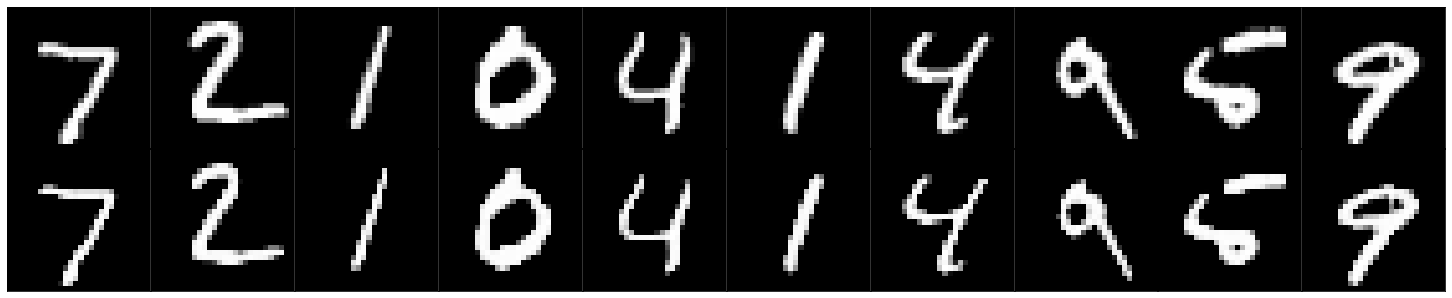

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [8]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [9]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation='relu')
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation='relu')
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation='relu')
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation='relu')
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(encoded, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation='relu')
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(encoded, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation='relu')
# Now 28x28x32

logits = tf.layers.conv2d(inputs_, 1, (3,3), padding='same', activation='relu')
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [10]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.8147
Epoch: 1/100... Training loss: 0.8139
Epoch: 1/100... Training loss: 0.8110
Epoch: 1/100... Training loss: 0.8116
Epoch: 1/100... Training loss: 0.8083
Epoch: 1/100... Training loss: 0.8081
Epoch: 1/100... Training loss: 0.8022
Epoch: 1/100... Training loss: 0.8040
Epoch: 1/100... Training loss: 0.8021
Epoch: 1/100... Training loss: 0.8048
Epoch: 1/100... Training loss: 0.8005
Epoch: 1/100... Training loss: 0.7966
Epoch: 1/100... Training loss: 0.7981
Epoch: 1/100... Training loss: 0.7980
Epoch: 1/100... Training loss: 0.7974
Epoch: 1/100... Training loss: 0.7951
Epoch: 1/100... Training loss: 0.7945
Epoch: 1/100... Training loss: 0.7920
Epoch: 1/100... Training loss: 0.7918
Epoch: 1/100... Training loss: 0.7868
Epoch: 1/100... Training loss: 0.7898
Epoch: 1/100... Training loss: 0.7889
Epoch: 1/100... Training loss: 0.7867
Epoch: 1/100... Training loss: 0.7852
Epoch: 1/100... Training loss: 0.7850
Epoch: 1/100... Training loss: 0.7791
Epoch: 1/100

Epoch: 1/100... Training loss: 0.6969
Epoch: 1/100... Training loss: 0.6966
Epoch: 1/100... Training loss: 0.6970
Epoch: 1/100... Training loss: 0.6966
Epoch: 1/100... Training loss: 0.6970
Epoch: 1/100... Training loss: 0.6967
Epoch: 1/100... Training loss: 0.6966
Epoch: 1/100... Training loss: 0.6964
Epoch: 1/100... Training loss: 0.6967
Epoch: 1/100... Training loss: 0.6966
Epoch: 1/100... Training loss: 0.6963
Epoch: 1/100... Training loss: 0.6965
Epoch: 1/100... Training loss: 0.6961
Epoch: 1/100... Training loss: 0.6964
Epoch: 1/100... Training loss: 0.6957
Epoch: 1/100... Training loss: 0.6963
Epoch: 1/100... Training loss: 0.6966
Epoch: 1/100... Training loss: 0.6959
Epoch: 1/100... Training loss: 0.6959
Epoch: 1/100... Training loss: 0.6959
Epoch: 1/100... Training loss: 0.6959
Epoch: 1/100... Training loss: 0.6958
Epoch: 1/100... Training loss: 0.6956
Epoch: 1/100... Training loss: 0.6958
Epoch: 1/100... Training loss: 0.6954
Epoch: 1/100... Training loss: 0.6953
Epoch: 1/100

Epoch: 2/100... Training loss: 0.6890
Epoch: 2/100... Training loss: 0.6897
Epoch: 2/100... Training loss: 0.6893
Epoch: 2/100... Training loss: 0.6890
Epoch: 2/100... Training loss: 0.6893
Epoch: 2/100... Training loss: 0.6894
Epoch: 2/100... Training loss: 0.6887
Epoch: 2/100... Training loss: 0.6892
Epoch: 2/100... Training loss: 0.6891
Epoch: 2/100... Training loss: 0.6896
Epoch: 2/100... Training loss: 0.6896
Epoch: 2/100... Training loss: 0.6893
Epoch: 2/100... Training loss: 0.6893
Epoch: 2/100... Training loss: 0.6894
Epoch: 2/100... Training loss: 0.6888
Epoch: 2/100... Training loss: 0.6889
Epoch: 2/100... Training loss: 0.6889
Epoch: 2/100... Training loss: 0.6894
Epoch: 2/100... Training loss: 0.6888
Epoch: 2/100... Training loss: 0.6892
Epoch: 2/100... Training loss: 0.6892
Epoch: 2/100... Training loss: 0.6889
Epoch: 2/100... Training loss: 0.6887
Epoch: 2/100... Training loss: 0.6888
Epoch: 2/100... Training loss: 0.6890
Epoch: 2/100... Training loss: 0.6892
Epoch: 2/100

Epoch: 3/100... Training loss: 0.6844
Epoch: 3/100... Training loss: 0.6853
Epoch: 3/100... Training loss: 0.6845
Epoch: 3/100... Training loss: 0.6851
Epoch: 3/100... Training loss: 0.6840
Epoch: 3/100... Training loss: 0.6849
Epoch: 3/100... Training loss: 0.6841
Epoch: 3/100... Training loss: 0.6847
Epoch: 3/100... Training loss: 0.6844
Epoch: 3/100... Training loss: 0.6844
Epoch: 3/100... Training loss: 0.6848
Epoch: 3/100... Training loss: 0.6851
Epoch: 3/100... Training loss: 0.6847
Epoch: 3/100... Training loss: 0.6842
Epoch: 3/100... Training loss: 0.6848
Epoch: 3/100... Training loss: 0.6842
Epoch: 3/100... Training loss: 0.6839
Epoch: 3/100... Training loss: 0.6840
Epoch: 3/100... Training loss: 0.6843
Epoch: 3/100... Training loss: 0.6840
Epoch: 3/100... Training loss: 0.6858
Epoch: 3/100... Training loss: 0.6841
Epoch: 3/100... Training loss: 0.6850
Epoch: 3/100... Training loss: 0.6845
Epoch: 3/100... Training loss: 0.6841
Epoch: 3/100... Training loss: 0.6844
Epoch: 3/100

Epoch: 4/100... Training loss: 0.6833
Epoch: 4/100... Training loss: 0.6826
Epoch: 4/100... Training loss: 0.6836
Epoch: 4/100... Training loss: 0.6833
Epoch: 4/100... Training loss: 0.6832
Epoch: 4/100... Training loss: 0.6826
Epoch: 4/100... Training loss: 0.6820
Epoch: 4/100... Training loss: 0.6835
Epoch: 4/100... Training loss: 0.6833
Epoch: 4/100... Training loss: 0.6828
Epoch: 4/100... Training loss: 0.6816
Epoch: 4/100... Training loss: 0.6820
Epoch: 4/100... Training loss: 0.6827
Epoch: 4/100... Training loss: 0.6822
Epoch: 4/100... Training loss: 0.6840
Epoch: 4/100... Training loss: 0.6828
Epoch: 4/100... Training loss: 0.6824
Epoch: 4/100... Training loss: 0.6826
Epoch: 4/100... Training loss: 0.6816
Epoch: 4/100... Training loss: 0.6819
Epoch: 4/100... Training loss: 0.6824
Epoch: 4/100... Training loss: 0.6826
Epoch: 4/100... Training loss: 0.6813
Epoch: 4/100... Training loss: 0.6829
Epoch: 4/100... Training loss: 0.6820
Epoch: 4/100... Training loss: 0.6830
Epoch: 4/100

Epoch: 4/100... Training loss: 0.6814
Epoch: 4/100... Training loss: 0.6818
Epoch: 4/100... Training loss: 0.6815
Epoch: 4/100... Training loss: 0.6810
Epoch: 4/100... Training loss: 0.6809
Epoch: 4/100... Training loss: 0.6815
Epoch: 4/100... Training loss: 0.6812
Epoch: 4/100... Training loss: 0.6816
Epoch: 4/100... Training loss: 0.6815
Epoch: 4/100... Training loss: 0.6813
Epoch: 4/100... Training loss: 0.6811
Epoch: 4/100... Training loss: 0.6813
Epoch: 4/100... Training loss: 0.6814
Epoch: 4/100... Training loss: 0.6804
Epoch: 4/100... Training loss: 0.6817
Epoch: 4/100... Training loss: 0.6811
Epoch: 4/100... Training loss: 0.6816
Epoch: 4/100... Training loss: 0.6807
Epoch: 4/100... Training loss: 0.6814
Epoch: 4/100... Training loss: 0.6824
Epoch: 4/100... Training loss: 0.6814
Epoch: 4/100... Training loss: 0.6809
Epoch: 4/100... Training loss: 0.6816
Epoch: 4/100... Training loss: 0.6817
Epoch: 4/100... Training loss: 0.6813
Epoch: 4/100... Training loss: 0.6808
Epoch: 4/100

Epoch: 5/100... Training loss: 0.6806
Epoch: 5/100... Training loss: 0.6803
Epoch: 5/100... Training loss: 0.6780
Epoch: 5/100... Training loss: 0.6806
Epoch: 5/100... Training loss: 0.6789
Epoch: 5/100... Training loss: 0.6805
Epoch: 5/100... Training loss: 0.6803
Epoch: 5/100... Training loss: 0.6801
Epoch: 5/100... Training loss: 0.6804
Epoch: 5/100... Training loss: 0.6809
Epoch: 5/100... Training loss: 0.6795
Epoch: 5/100... Training loss: 0.6789
Epoch: 5/100... Training loss: 0.6792
Epoch: 5/100... Training loss: 0.6800
Epoch: 5/100... Training loss: 0.6802
Epoch: 5/100... Training loss: 0.6796
Epoch: 5/100... Training loss: 0.6791
Epoch: 5/100... Training loss: 0.6794
Epoch: 5/100... Training loss: 0.6798
Epoch: 5/100... Training loss: 0.6802
Epoch: 5/100... Training loss: 0.6808
Epoch: 5/100... Training loss: 0.6799
Epoch: 5/100... Training loss: 0.6793
Epoch: 5/100... Training loss: 0.6801
Epoch: 5/100... Training loss: 0.6788
Epoch: 5/100... Training loss: 0.6801
Epoch: 5/100

Epoch: 6/100... Training loss: 0.6782
Epoch: 6/100... Training loss: 0.6801
Epoch: 6/100... Training loss: 0.6789
Epoch: 6/100... Training loss: 0.6783
Epoch: 6/100... Training loss: 0.6774
Epoch: 6/100... Training loss: 0.6795
Epoch: 6/100... Training loss: 0.6796
Epoch: 6/100... Training loss: 0.6775
Epoch: 6/100... Training loss: 0.6777
Epoch: 6/100... Training loss: 0.6784
Epoch: 6/100... Training loss: 0.6780
Epoch: 6/100... Training loss: 0.6797
Epoch: 6/100... Training loss: 0.6783
Epoch: 6/100... Training loss: 0.6778
Epoch: 6/100... Training loss: 0.6786
Epoch: 6/100... Training loss: 0.6788
Epoch: 6/100... Training loss: 0.6779
Epoch: 6/100... Training loss: 0.6789
Epoch: 6/100... Training loss: 0.6785
Epoch: 6/100... Training loss: 0.6789
Epoch: 6/100... Training loss: 0.6788
Epoch: 6/100... Training loss: 0.6784
Epoch: 6/100... Training loss: 0.6781
Epoch: 6/100... Training loss: 0.6781
Epoch: 6/100... Training loss: 0.6775
Epoch: 6/100... Training loss: 0.6789
Epoch: 6/100

Epoch: 7/100... Training loss: 0.6771
Epoch: 7/100... Training loss: 0.6768
Epoch: 7/100... Training loss: 0.6778
Epoch: 7/100... Training loss: 0.6770
Epoch: 7/100... Training loss: 0.6773
Epoch: 7/100... Training loss: 0.6769
Epoch: 7/100... Training loss: 0.6766
Epoch: 7/100... Training loss: 0.6772
Epoch: 7/100... Training loss: 0.6760
Epoch: 7/100... Training loss: 0.6770
Epoch: 7/100... Training loss: 0.6774
Epoch: 7/100... Training loss: 0.6769
Epoch: 7/100... Training loss: 0.6755
Epoch: 7/100... Training loss: 0.6775
Epoch: 7/100... Training loss: 0.6759
Epoch: 7/100... Training loss: 0.6766
Epoch: 7/100... Training loss: 0.6769
Epoch: 7/100... Training loss: 0.6776
Epoch: 7/100... Training loss: 0.6781
Epoch: 7/100... Training loss: 0.6755
Epoch: 7/100... Training loss: 0.6773
Epoch: 7/100... Training loss: 0.6773
Epoch: 7/100... Training loss: 0.6774
Epoch: 7/100... Training loss: 0.6764
Epoch: 7/100... Training loss: 0.6759
Epoch: 7/100... Training loss: 0.6775
Epoch: 7/100

Epoch: 7/100... Training loss: 0.6763
Epoch: 7/100... Training loss: 0.6764
Epoch: 7/100... Training loss: 0.6755
Epoch: 7/100... Training loss: 0.6773
Epoch: 7/100... Training loss: 0.6765
Epoch: 7/100... Training loss: 0.6757
Epoch: 7/100... Training loss: 0.6770
Epoch: 7/100... Training loss: 0.6763
Epoch: 7/100... Training loss: 0.6766
Epoch: 7/100... Training loss: 0.6760
Epoch: 7/100... Training loss: 0.6757
Epoch: 7/100... Training loss: 0.6756
Epoch: 7/100... Training loss: 0.6750
Epoch: 7/100... Training loss: 0.6752
Epoch: 7/100... Training loss: 0.6768
Epoch: 7/100... Training loss: 0.6764
Epoch: 7/100... Training loss: 0.6752
Epoch: 7/100... Training loss: 0.6761
Epoch: 7/100... Training loss: 0.6741
Epoch: 7/100... Training loss: 0.6757
Epoch: 7/100... Training loss: 0.6763
Epoch: 7/100... Training loss: 0.6751
Epoch: 7/100... Training loss: 0.6755
Epoch: 7/100... Training loss: 0.6755
Epoch: 7/100... Training loss: 0.6760
Epoch: 7/100... Training loss: 0.6760
Epoch: 7/100

Epoch: 8/100... Training loss: 0.6752
Epoch: 8/100... Training loss: 0.6736
Epoch: 8/100... Training loss: 0.6734
Epoch: 8/100... Training loss: 0.6745
Epoch: 8/100... Training loss: 0.6749
Epoch: 8/100... Training loss: 0.6748
Epoch: 8/100... Training loss: 0.6735
Epoch: 8/100... Training loss: 0.6751
Epoch: 8/100... Training loss: 0.6723
Epoch: 8/100... Training loss: 0.6760
Epoch: 8/100... Training loss: 0.6743
Epoch: 8/100... Training loss: 0.6748
Epoch: 8/100... Training loss: 0.6738
Epoch: 8/100... Training loss: 0.6750
Epoch: 8/100... Training loss: 0.6728
Epoch: 8/100... Training loss: 0.6756
Epoch: 8/100... Training loss: 0.6731
Epoch: 8/100... Training loss: 0.6750
Epoch: 8/100... Training loss: 0.6757
Epoch: 8/100... Training loss: 0.6739
Epoch: 8/100... Training loss: 0.6749
Epoch: 8/100... Training loss: 0.6745
Epoch: 8/100... Training loss: 0.6763
Epoch: 8/100... Training loss: 0.6730
Epoch: 8/100... Training loss: 0.6746
Epoch: 8/100... Training loss: 0.6744
Epoch: 8/100

Epoch: 9/100... Training loss: 0.6720
Epoch: 9/100... Training loss: 0.6719
Epoch: 9/100... Training loss: 0.6756
Epoch: 9/100... Training loss: 0.6730
Epoch: 9/100... Training loss: 0.6746
Epoch: 9/100... Training loss: 0.6746
Epoch: 9/100... Training loss: 0.6743
Epoch: 9/100... Training loss: 0.6727
Epoch: 9/100... Training loss: 0.6731
Epoch: 9/100... Training loss: 0.6755
Epoch: 9/100... Training loss: 0.6730
Epoch: 9/100... Training loss: 0.6737
Epoch: 9/100... Training loss: 0.6738
Epoch: 9/100... Training loss: 0.6740
Epoch: 9/100... Training loss: 0.6741
Epoch: 9/100... Training loss: 0.6721
Epoch: 9/100... Training loss: 0.6737
Epoch: 9/100... Training loss: 0.6743
Epoch: 9/100... Training loss: 0.6723
Epoch: 9/100... Training loss: 0.6721
Epoch: 9/100... Training loss: 0.6752
Epoch: 9/100... Training loss: 0.6743
Epoch: 9/100... Training loss: 0.6736
Epoch: 9/100... Training loss: 0.6736
Epoch: 9/100... Training loss: 0.6732
Epoch: 9/100... Training loss: 0.6744
Epoch: 9/100

Epoch: 9/100... Training loss: 0.6713
Epoch: 9/100... Training loss: 0.6722
Epoch: 9/100... Training loss: 0.6733
Epoch: 9/100... Training loss: 0.6724
Epoch: 9/100... Training loss: 0.6712
Epoch: 9/100... Training loss: 0.6722
Epoch: 9/100... Training loss: 0.6728
Epoch: 9/100... Training loss: 0.6740
Epoch: 9/100... Training loss: 0.6703
Epoch: 9/100... Training loss: 0.6722
Epoch: 9/100... Training loss: 0.6726
Epoch: 9/100... Training loss: 0.6709
Epoch: 9/100... Training loss: 0.6712
Epoch: 9/100... Training loss: 0.6726
Epoch: 9/100... Training loss: 0.6730
Epoch: 9/100... Training loss: 0.6729
Epoch: 9/100... Training loss: 0.6728
Epoch: 9/100... Training loss: 0.6721
Epoch: 9/100... Training loss: 0.6727
Epoch: 9/100... Training loss: 0.6714
Epoch: 9/100... Training loss: 0.6717
Epoch: 9/100... Training loss: 0.6727
Epoch: 9/100... Training loss: 0.6730
Epoch: 10/100... Training loss: 0.6730
Epoch: 10/100... Training loss: 0.6745
Epoch: 10/100... Training loss: 0.6705
Epoch: 10

Epoch: 10/100... Training loss: 0.6708
Epoch: 10/100... Training loss: 0.6715
Epoch: 10/100... Training loss: 0.6721
Epoch: 10/100... Training loss: 0.6707
Epoch: 10/100... Training loss: 0.6704
Epoch: 10/100... Training loss: 0.6718
Epoch: 10/100... Training loss: 0.6697
Epoch: 10/100... Training loss: 0.6712
Epoch: 10/100... Training loss: 0.6706
Epoch: 10/100... Training loss: 0.6720
Epoch: 10/100... Training loss: 0.6718
Epoch: 10/100... Training loss: 0.6702
Epoch: 10/100... Training loss: 0.6704
Epoch: 10/100... Training loss: 0.6733
Epoch: 10/100... Training loss: 0.6714
Epoch: 10/100... Training loss: 0.6723
Epoch: 10/100... Training loss: 0.6699
Epoch: 10/100... Training loss: 0.6729
Epoch: 10/100... Training loss: 0.6731
Epoch: 10/100... Training loss: 0.6718
Epoch: 10/100... Training loss: 0.6698
Epoch: 10/100... Training loss: 0.6691
Epoch: 10/100... Training loss: 0.6714
Epoch: 10/100... Training loss: 0.6712
Epoch: 10/100... Training loss: 0.6702
Epoch: 10/100... Training

Epoch: 11/100... Training loss: 0.6697
Epoch: 11/100... Training loss: 0.6698
Epoch: 11/100... Training loss: 0.6710
Epoch: 11/100... Training loss: 0.6696
Epoch: 11/100... Training loss: 0.6703
Epoch: 11/100... Training loss: 0.6696
Epoch: 11/100... Training loss: 0.6702
Epoch: 11/100... Training loss: 0.6707
Epoch: 11/100... Training loss: 0.6721
Epoch: 11/100... Training loss: 0.6703
Epoch: 11/100... Training loss: 0.6718
Epoch: 11/100... Training loss: 0.6701
Epoch: 11/100... Training loss: 0.6696
Epoch: 11/100... Training loss: 0.6696
Epoch: 11/100... Training loss: 0.6691
Epoch: 11/100... Training loss: 0.6698
Epoch: 11/100... Training loss: 0.6706
Epoch: 11/100... Training loss: 0.6712
Epoch: 11/100... Training loss: 0.6708
Epoch: 11/100... Training loss: 0.6705
Epoch: 11/100... Training loss: 0.6692
Epoch: 11/100... Training loss: 0.6713
Epoch: 11/100... Training loss: 0.6691
Epoch: 11/100... Training loss: 0.6713
Epoch: 11/100... Training loss: 0.6717
Epoch: 11/100... Training

Epoch: 12/100... Training loss: 0.6692
Epoch: 12/100... Training loss: 0.6685
Epoch: 12/100... Training loss: 0.6727
Epoch: 12/100... Training loss: 0.6705
Epoch: 12/100... Training loss: 0.6676
Epoch: 12/100... Training loss: 0.6682
Epoch: 12/100... Training loss: 0.6688
Epoch: 12/100... Training loss: 0.6682
Epoch: 12/100... Training loss: 0.6692
Epoch: 12/100... Training loss: 0.6671
Epoch: 12/100... Training loss: 0.6692
Epoch: 12/100... Training loss: 0.6694
Epoch: 12/100... Training loss: 0.6690
Epoch: 12/100... Training loss: 0.6678
Epoch: 12/100... Training loss: 0.6701
Epoch: 12/100... Training loss: 0.6697
Epoch: 12/100... Training loss: 0.6696
Epoch: 12/100... Training loss: 0.6708
Epoch: 12/100... Training loss: 0.6716
Epoch: 12/100... Training loss: 0.6677
Epoch: 12/100... Training loss: 0.6710
Epoch: 12/100... Training loss: 0.6694
Epoch: 12/100... Training loss: 0.6677
Epoch: 12/100... Training loss: 0.6709
Epoch: 12/100... Training loss: 0.6693
Epoch: 12/100... Training

Epoch: 12/100... Training loss: 0.6697
Epoch: 12/100... Training loss: 0.6689
Epoch: 12/100... Training loss: 0.6678
Epoch: 12/100... Training loss: 0.6677
Epoch: 12/100... Training loss: 0.6685
Epoch: 12/100... Training loss: 0.6688
Epoch: 12/100... Training loss: 0.6664
Epoch: 12/100... Training loss: 0.6669
Epoch: 12/100... Training loss: 0.6663
Epoch: 12/100... Training loss: 0.6689
Epoch: 12/100... Training loss: 0.6694
Epoch: 12/100... Training loss: 0.6670
Epoch: 12/100... Training loss: 0.6674
Epoch: 12/100... Training loss: 0.6684
Epoch: 12/100... Training loss: 0.6681
Epoch: 12/100... Training loss: 0.6682
Epoch: 12/100... Training loss: 0.6688
Epoch: 12/100... Training loss: 0.6681
Epoch: 12/100... Training loss: 0.6699
Epoch: 12/100... Training loss: 0.6686
Epoch: 12/100... Training loss: 0.6690
Epoch: 12/100... Training loss: 0.6685
Epoch: 12/100... Training loss: 0.6684
Epoch: 12/100... Training loss: 0.6668
Epoch: 12/100... Training loss: 0.6688
Epoch: 12/100... Training

Epoch: 13/100... Training loss: 0.6668
Epoch: 13/100... Training loss: 0.6668
Epoch: 13/100... Training loss: 0.6677
Epoch: 13/100... Training loss: 0.6683
Epoch: 13/100... Training loss: 0.6668
Epoch: 13/100... Training loss: 0.6693
Epoch: 13/100... Training loss: 0.6680
Epoch: 13/100... Training loss: 0.6676
Epoch: 13/100... Training loss: 0.6653
Epoch: 13/100... Training loss: 0.6670
Epoch: 13/100... Training loss: 0.6668
Epoch: 13/100... Training loss: 0.6664
Epoch: 13/100... Training loss: 0.6667
Epoch: 13/100... Training loss: 0.6664
Epoch: 13/100... Training loss: 0.6662
Epoch: 13/100... Training loss: 0.6675
Epoch: 13/100... Training loss: 0.6677
Epoch: 13/100... Training loss: 0.6680
Epoch: 13/100... Training loss: 0.6694
Epoch: 13/100... Training loss: 0.6684
Epoch: 13/100... Training loss: 0.6689
Epoch: 13/100... Training loss: 0.6664
Epoch: 13/100... Training loss: 0.6669
Epoch: 13/100... Training loss: 0.6673
Epoch: 13/100... Training loss: 0.6684
Epoch: 13/100... Training

Epoch: 14/100... Training loss: 0.6663
Epoch: 14/100... Training loss: 0.6651
Epoch: 14/100... Training loss: 0.6650
Epoch: 14/100... Training loss: 0.6667
Epoch: 14/100... Training loss: 0.6653
Epoch: 14/100... Training loss: 0.6666
Epoch: 14/100... Training loss: 0.6670
Epoch: 14/100... Training loss: 0.6665
Epoch: 14/100... Training loss: 0.6660
Epoch: 14/100... Training loss: 0.6686
Epoch: 14/100... Training loss: 0.6663
Epoch: 14/100... Training loss: 0.6666
Epoch: 14/100... Training loss: 0.6659
Epoch: 14/100... Training loss: 0.6672
Epoch: 14/100... Training loss: 0.6668
Epoch: 14/100... Training loss: 0.6665
Epoch: 14/100... Training loss: 0.6646
Epoch: 14/100... Training loss: 0.6655
Epoch: 14/100... Training loss: 0.6645
Epoch: 14/100... Training loss: 0.6685
Epoch: 14/100... Training loss: 0.6651
Epoch: 14/100... Training loss: 0.6670
Epoch: 14/100... Training loss: 0.6668
Epoch: 14/100... Training loss: 0.6667
Epoch: 14/100... Training loss: 0.6654
Epoch: 14/100... Training

Epoch: 15/100... Training loss: 0.6656
Epoch: 15/100... Training loss: 0.6658
Epoch: 15/100... Training loss: 0.6667
Epoch: 15/100... Training loss: 0.6651
Epoch: 15/100... Training loss: 0.6645
Epoch: 15/100... Training loss: 0.6645
Epoch: 15/100... Training loss: 0.6661
Epoch: 15/100... Training loss: 0.6623
Epoch: 15/100... Training loss: 0.6675
Epoch: 15/100... Training loss: 0.6636
Epoch: 15/100... Training loss: 0.6649
Epoch: 15/100... Training loss: 0.6663
Epoch: 15/100... Training loss: 0.6667
Epoch: 15/100... Training loss: 0.6660
Epoch: 15/100... Training loss: 0.6663
Epoch: 15/100... Training loss: 0.6667
Epoch: 15/100... Training loss: 0.6643
Epoch: 15/100... Training loss: 0.6639
Epoch: 15/100... Training loss: 0.6673
Epoch: 15/100... Training loss: 0.6655
Epoch: 15/100... Training loss: 0.6661
Epoch: 15/100... Training loss: 0.6666
Epoch: 15/100... Training loss: 0.6658
Epoch: 15/100... Training loss: 0.6668
Epoch: 15/100... Training loss: 0.6641
Epoch: 15/100... Training

Epoch: 15/100... Training loss: 0.6638
Epoch: 15/100... Training loss: 0.6647
Epoch: 15/100... Training loss: 0.6667
Epoch: 15/100... Training loss: 0.6666
Epoch: 15/100... Training loss: 0.6658
Epoch: 15/100... Training loss: 0.6637
Epoch: 15/100... Training loss: 0.6669
Epoch: 15/100... Training loss: 0.6645
Epoch: 15/100... Training loss: 0.6666
Epoch: 15/100... Training loss: 0.6652
Epoch: 15/100... Training loss: 0.6630
Epoch: 15/100... Training loss: 0.6660
Epoch: 15/100... Training loss: 0.6640
Epoch: 15/100... Training loss: 0.6646
Epoch: 15/100... Training loss: 0.6648
Epoch: 15/100... Training loss: 0.6655
Epoch: 15/100... Training loss: 0.6644
Epoch: 15/100... Training loss: 0.6635
Epoch: 15/100... Training loss: 0.6633
Epoch: 15/100... Training loss: 0.6652
Epoch: 15/100... Training loss: 0.6647
Epoch: 15/100... Training loss: 0.6650
Epoch: 15/100... Training loss: 0.6635
Epoch: 15/100... Training loss: 0.6654
Epoch: 15/100... Training loss: 0.6643
Epoch: 15/100... Training

Epoch: 16/100... Training loss: 0.6655
Epoch: 16/100... Training loss: 0.6637
Epoch: 16/100... Training loss: 0.6636
Epoch: 16/100... Training loss: 0.6632
Epoch: 16/100... Training loss: 0.6665
Epoch: 16/100... Training loss: 0.6641
Epoch: 16/100... Training loss: 0.6634
Epoch: 16/100... Training loss: 0.6653
Epoch: 16/100... Training loss: 0.6641
Epoch: 16/100... Training loss: 0.6622
Epoch: 16/100... Training loss: 0.6669
Epoch: 16/100... Training loss: 0.6643
Epoch: 16/100... Training loss: 0.6635
Epoch: 16/100... Training loss: 0.6627
Epoch: 16/100... Training loss: 0.6650
Epoch: 16/100... Training loss: 0.6613
Epoch: 16/100... Training loss: 0.6660
Epoch: 16/100... Training loss: 0.6671
Epoch: 16/100... Training loss: 0.6657
Epoch: 16/100... Training loss: 0.6660
Epoch: 16/100... Training loss: 0.6634
Epoch: 16/100... Training loss: 0.6660
Epoch: 16/100... Training loss: 0.6638
Epoch: 16/100... Training loss: 0.6637
Epoch: 16/100... Training loss: 0.6644
Epoch: 16/100... Training

Epoch: 17/100... Training loss: 0.6635
Epoch: 17/100... Training loss: 0.6638
Epoch: 17/100... Training loss: 0.6644
Epoch: 17/100... Training loss: 0.6650
Epoch: 17/100... Training loss: 0.6634
Epoch: 17/100... Training loss: 0.6651
Epoch: 17/100... Training loss: 0.6633
Epoch: 17/100... Training loss: 0.6632
Epoch: 17/100... Training loss: 0.6638
Epoch: 17/100... Training loss: 0.6646
Epoch: 17/100... Training loss: 0.6649
Epoch: 17/100... Training loss: 0.6648
Epoch: 17/100... Training loss: 0.6620
Epoch: 17/100... Training loss: 0.6633
Epoch: 17/100... Training loss: 0.6623
Epoch: 17/100... Training loss: 0.6649
Epoch: 17/100... Training loss: 0.6611
Epoch: 17/100... Training loss: 0.6634
Epoch: 17/100... Training loss: 0.6638
Epoch: 17/100... Training loss: 0.6627
Epoch: 17/100... Training loss: 0.6622
Epoch: 17/100... Training loss: 0.6649
Epoch: 17/100... Training loss: 0.6648
Epoch: 17/100... Training loss: 0.6660
Epoch: 17/100... Training loss: 0.6659
Epoch: 17/100... Training

Epoch: 17/100... Training loss: 0.6624
Epoch: 17/100... Training loss: 0.6624
Epoch: 17/100... Training loss: 0.6646
Epoch: 17/100... Training loss: 0.6653
Epoch: 17/100... Training loss: 0.6633
Epoch: 17/100... Training loss: 0.6622
Epoch: 17/100... Training loss: 0.6622
Epoch: 17/100... Training loss: 0.6627
Epoch: 17/100... Training loss: 0.6642
Epoch: 17/100... Training loss: 0.6617
Epoch: 17/100... Training loss: 0.6637
Epoch: 17/100... Training loss: 0.6643
Epoch: 17/100... Training loss: 0.6637
Epoch: 17/100... Training loss: 0.6626
Epoch: 17/100... Training loss: 0.6627
Epoch: 17/100... Training loss: 0.6628
Epoch: 17/100... Training loss: 0.6629
Epoch: 17/100... Training loss: 0.6634
Epoch: 17/100... Training loss: 0.6628
Epoch: 17/100... Training loss: 0.6632
Epoch: 17/100... Training loss: 0.6618
Epoch: 17/100... Training loss: 0.6623
Epoch: 17/100... Training loss: 0.6633
Epoch: 18/100... Training loss: 0.6622
Epoch: 18/100... Training loss: 0.6634
Epoch: 18/100... Training

Epoch: 18/100... Training loss: 0.6639
Epoch: 18/100... Training loss: 0.6632
Epoch: 18/100... Training loss: 0.6615
Epoch: 18/100... Training loss: 0.6644
Epoch: 18/100... Training loss: 0.6605
Epoch: 18/100... Training loss: 0.6621
Epoch: 18/100... Training loss: 0.6626
Epoch: 18/100... Training loss: 0.6623
Epoch: 18/100... Training loss: 0.6628
Epoch: 18/100... Training loss: 0.6637
Epoch: 18/100... Training loss: 0.6593
Epoch: 18/100... Training loss: 0.6634
Epoch: 18/100... Training loss: 0.6652
Epoch: 18/100... Training loss: 0.6614
Epoch: 18/100... Training loss: 0.6617
Epoch: 18/100... Training loss: 0.6628
Epoch: 18/100... Training loss: 0.6608
Epoch: 18/100... Training loss: 0.6591
Epoch: 18/100... Training loss: 0.6629
Epoch: 18/100... Training loss: 0.6603
Epoch: 18/100... Training loss: 0.6635
Epoch: 18/100... Training loss: 0.6637
Epoch: 18/100... Training loss: 0.6613
Epoch: 18/100... Training loss: 0.6604
Epoch: 18/100... Training loss: 0.6615
Epoch: 18/100... Training

Epoch: 19/100... Training loss: 0.6603
Epoch: 19/100... Training loss: 0.6630
Epoch: 19/100... Training loss: 0.6629
Epoch: 19/100... Training loss: 0.6634
Epoch: 19/100... Training loss: 0.6621
Epoch: 19/100... Training loss: 0.6636
Epoch: 19/100... Training loss: 0.6619
Epoch: 19/100... Training loss: 0.6594
Epoch: 19/100... Training loss: 0.6637
Epoch: 19/100... Training loss: 0.6640
Epoch: 19/100... Training loss: 0.6624
Epoch: 19/100... Training loss: 0.6618
Epoch: 19/100... Training loss: 0.6628
Epoch: 19/100... Training loss: 0.6597
Epoch: 19/100... Training loss: 0.6592
Epoch: 19/100... Training loss: 0.6631
Epoch: 19/100... Training loss: 0.6632
Epoch: 19/100... Training loss: 0.6597
Epoch: 19/100... Training loss: 0.6637
Epoch: 19/100... Training loss: 0.6634
Epoch: 19/100... Training loss: 0.6627
Epoch: 19/100... Training loss: 0.6639
Epoch: 19/100... Training loss: 0.6617
Epoch: 19/100... Training loss: 0.6618
Epoch: 19/100... Training loss: 0.6599
Epoch: 19/100... Training

Epoch: 20/100... Training loss: 0.6609
Epoch: 20/100... Training loss: 0.6585
Epoch: 20/100... Training loss: 0.6622
Epoch: 20/100... Training loss: 0.6616
Epoch: 20/100... Training loss: 0.6598
Epoch: 20/100... Training loss: 0.6570
Epoch: 20/100... Training loss: 0.6604
Epoch: 20/100... Training loss: 0.6640
Epoch: 20/100... Training loss: 0.6617
Epoch: 20/100... Training loss: 0.6618
Epoch: 20/100... Training loss: 0.6615
Epoch: 20/100... Training loss: 0.6622
Epoch: 20/100... Training loss: 0.6600
Epoch: 20/100... Training loss: 0.6622
Epoch: 20/100... Training loss: 0.6612
Epoch: 20/100... Training loss: 0.6610
Epoch: 20/100... Training loss: 0.6621
Epoch: 20/100... Training loss: 0.6610
Epoch: 20/100... Training loss: 0.6610
Epoch: 20/100... Training loss: 0.6598
Epoch: 20/100... Training loss: 0.6603
Epoch: 20/100... Training loss: 0.6613
Epoch: 20/100... Training loss: 0.6601
Epoch: 20/100... Training loss: 0.6617
Epoch: 20/100... Training loss: 0.6612
Epoch: 20/100... Training

Epoch: 20/100... Training loss: 0.6593
Epoch: 20/100... Training loss: 0.6615
Epoch: 20/100... Training loss: 0.6611
Epoch: 20/100... Training loss: 0.6594
Epoch: 20/100... Training loss: 0.6581
Epoch: 20/100... Training loss: 0.6621
Epoch: 20/100... Training loss: 0.6602
Epoch: 20/100... Training loss: 0.6596
Epoch: 20/100... Training loss: 0.6619
Epoch: 20/100... Training loss: 0.6607
Epoch: 20/100... Training loss: 0.6645
Epoch: 20/100... Training loss: 0.6640
Epoch: 20/100... Training loss: 0.6648
Epoch: 20/100... Training loss: 0.6618
Epoch: 20/100... Training loss: 0.6596
Epoch: 20/100... Training loss: 0.6625
Epoch: 20/100... Training loss: 0.6607
Epoch: 20/100... Training loss: 0.6610
Epoch: 20/100... Training loss: 0.6621
Epoch: 20/100... Training loss: 0.6613
Epoch: 20/100... Training loss: 0.6619
Epoch: 20/100... Training loss: 0.6626
Epoch: 20/100... Training loss: 0.6616
Epoch: 20/100... Training loss: 0.6610
Epoch: 20/100... Training loss: 0.6620
Epoch: 20/100... Training

Epoch: 21/100... Training loss: 0.6610
Epoch: 21/100... Training loss: 0.6618
Epoch: 21/100... Training loss: 0.6621
Epoch: 21/100... Training loss: 0.6594
Epoch: 21/100... Training loss: 0.6606
Epoch: 21/100... Training loss: 0.6605
Epoch: 21/100... Training loss: 0.6624
Epoch: 21/100... Training loss: 0.6567
Epoch: 21/100... Training loss: 0.6632
Epoch: 21/100... Training loss: 0.6581
Epoch: 21/100... Training loss: 0.6608
Epoch: 21/100... Training loss: 0.6600
Epoch: 21/100... Training loss: 0.6597
Epoch: 21/100... Training loss: 0.6596
Epoch: 21/100... Training loss: 0.6617
Epoch: 21/100... Training loss: 0.6591
Epoch: 21/100... Training loss: 0.6593
Epoch: 21/100... Training loss: 0.6582
Epoch: 21/100... Training loss: 0.6593
Epoch: 21/100... Training loss: 0.6583
Epoch: 21/100... Training loss: 0.6622
Epoch: 21/100... Training loss: 0.6603
Epoch: 21/100... Training loss: 0.6616
Epoch: 21/100... Training loss: 0.6598
Epoch: 21/100... Training loss: 0.6604
Epoch: 21/100... Training

Epoch: 22/100... Training loss: 0.6604
Epoch: 22/100... Training loss: 0.6605
Epoch: 22/100... Training loss: 0.6595
Epoch: 22/100... Training loss: 0.6603
Epoch: 22/100... Training loss: 0.6570
Epoch: 22/100... Training loss: 0.6564
Epoch: 22/100... Training loss: 0.6600
Epoch: 22/100... Training loss: 0.6594
Epoch: 22/100... Training loss: 0.6605
Epoch: 22/100... Training loss: 0.6609
Epoch: 22/100... Training loss: 0.6595
Epoch: 22/100... Training loss: 0.6609
Epoch: 22/100... Training loss: 0.6592
Epoch: 22/100... Training loss: 0.6609
Epoch: 22/100... Training loss: 0.6609
Epoch: 22/100... Training loss: 0.6611
Epoch: 22/100... Training loss: 0.6586
Epoch: 22/100... Training loss: 0.6609
Epoch: 22/100... Training loss: 0.6609
Epoch: 22/100... Training loss: 0.6594
Epoch: 22/100... Training loss: 0.6603
Epoch: 22/100... Training loss: 0.6600
Epoch: 22/100... Training loss: 0.6615
Epoch: 22/100... Training loss: 0.6592
Epoch: 22/100... Training loss: 0.6607
Epoch: 22/100... Training

Epoch: 23/100... Training loss: 0.6579
Epoch: 23/100... Training loss: 0.6599
Epoch: 23/100... Training loss: 0.6586
Epoch: 23/100... Training loss: 0.6582
Epoch: 23/100... Training loss: 0.6588
Epoch: 23/100... Training loss: 0.6597
Epoch: 23/100... Training loss: 0.6623
Epoch: 23/100... Training loss: 0.6609
Epoch: 23/100... Training loss: 0.6565
Epoch: 23/100... Training loss: 0.6629
Epoch: 23/100... Training loss: 0.6576
Epoch: 23/100... Training loss: 0.6601
Epoch: 23/100... Training loss: 0.6597
Epoch: 23/100... Training loss: 0.6609
Epoch: 23/100... Training loss: 0.6611
Epoch: 23/100... Training loss: 0.6621
Epoch: 23/100... Training loss: 0.6605
Epoch: 23/100... Training loss: 0.6591
Epoch: 23/100... Training loss: 0.6599
Epoch: 23/100... Training loss: 0.6589
Epoch: 23/100... Training loss: 0.6605
Epoch: 23/100... Training loss: 0.6605
Epoch: 23/100... Training loss: 0.6586
Epoch: 23/100... Training loss: 0.6610
Epoch: 23/100... Training loss: 0.6592
Epoch: 23/100... Training

Epoch: 23/100... Training loss: 0.6622
Epoch: 23/100... Training loss: 0.6579
Epoch: 23/100... Training loss: 0.6612
Epoch: 23/100... Training loss: 0.6589
Epoch: 23/100... Training loss: 0.6624
Epoch: 23/100... Training loss: 0.6608
Epoch: 23/100... Training loss: 0.6598
Epoch: 23/100... Training loss: 0.6602
Epoch: 23/100... Training loss: 0.6570
Epoch: 23/100... Training loss: 0.6606
Epoch: 23/100... Training loss: 0.6567
Epoch: 23/100... Training loss: 0.6623
Epoch: 23/100... Training loss: 0.6581
Epoch: 23/100... Training loss: 0.6600
Epoch: 23/100... Training loss: 0.6573
Epoch: 23/100... Training loss: 0.6568
Epoch: 23/100... Training loss: 0.6587
Epoch: 23/100... Training loss: 0.6585
Epoch: 23/100... Training loss: 0.6614
Epoch: 23/100... Training loss: 0.6585
Epoch: 23/100... Training loss: 0.6579
Epoch: 23/100... Training loss: 0.6598
Epoch: 23/100... Training loss: 0.6601
Epoch: 23/100... Training loss: 0.6606
Epoch: 23/100... Training loss: 0.6599
Epoch: 23/100... Training

Epoch: 24/100... Training loss: 0.6611
Epoch: 24/100... Training loss: 0.6626
Epoch: 24/100... Training loss: 0.6588
Epoch: 24/100... Training loss: 0.6595
Epoch: 24/100... Training loss: 0.6585
Epoch: 24/100... Training loss: 0.6573
Epoch: 24/100... Training loss: 0.6581
Epoch: 24/100... Training loss: 0.6595
Epoch: 24/100... Training loss: 0.6592
Epoch: 24/100... Training loss: 0.6592
Epoch: 24/100... Training loss: 0.6588
Epoch: 24/100... Training loss: 0.6581
Epoch: 24/100... Training loss: 0.6596
Epoch: 24/100... Training loss: 0.6587
Epoch: 24/100... Training loss: 0.6582
Epoch: 24/100... Training loss: 0.6598
Epoch: 24/100... Training loss: 0.6578
Epoch: 24/100... Training loss: 0.6588
Epoch: 24/100... Training loss: 0.6576
Epoch: 24/100... Training loss: 0.6588
Epoch: 24/100... Training loss: 0.6603
Epoch: 24/100... Training loss: 0.6577
Epoch: 24/100... Training loss: 0.6619
Epoch: 24/100... Training loss: 0.6589
Epoch: 24/100... Training loss: 0.6593
Epoch: 24/100... Training

Epoch: 25/100... Training loss: 0.6570
Epoch: 25/100... Training loss: 0.6580
Epoch: 25/100... Training loss: 0.6586
Epoch: 25/100... Training loss: 0.6579
Epoch: 25/100... Training loss: 0.6585
Epoch: 25/100... Training loss: 0.6601
Epoch: 25/100... Training loss: 0.6599
Epoch: 25/100... Training loss: 0.6608
Epoch: 25/100... Training loss: 0.6577
Epoch: 25/100... Training loss: 0.6596
Epoch: 25/100... Training loss: 0.6566
Epoch: 25/100... Training loss: 0.6583
Epoch: 25/100... Training loss: 0.6602
Epoch: 25/100... Training loss: 0.6590
Epoch: 25/100... Training loss: 0.6598
Epoch: 25/100... Training loss: 0.6594
Epoch: 25/100... Training loss: 0.6561
Epoch: 25/100... Training loss: 0.6590
Epoch: 25/100... Training loss: 0.6574
Epoch: 25/100... Training loss: 0.6573
Epoch: 25/100... Training loss: 0.6588
Epoch: 25/100... Training loss: 0.6618
Epoch: 25/100... Training loss: 0.6584
Epoch: 25/100... Training loss: 0.6584
Epoch: 25/100... Training loss: 0.6602
Epoch: 25/100... Training

Epoch: 25/100... Training loss: 0.6580
Epoch: 25/100... Training loss: 0.6597
Epoch: 25/100... Training loss: 0.6587
Epoch: 25/100... Training loss: 0.6561
Epoch: 25/100... Training loss: 0.6577
Epoch: 25/100... Training loss: 0.6586
Epoch: 25/100... Training loss: 0.6579
Epoch: 25/100... Training loss: 0.6575
Epoch: 25/100... Training loss: 0.6559
Epoch: 25/100... Training loss: 0.6592
Epoch: 25/100... Training loss: 0.6589
Epoch: 25/100... Training loss: 0.6582
Epoch: 25/100... Training loss: 0.6570
Epoch: 25/100... Training loss: 0.6600
Epoch: 25/100... Training loss: 0.6577
Epoch: 26/100... Training loss: 0.6540
Epoch: 26/100... Training loss: 0.6568
Epoch: 26/100... Training loss: 0.6581
Epoch: 26/100... Training loss: 0.6587
Epoch: 26/100... Training loss: 0.6595
Epoch: 26/100... Training loss: 0.6556
Epoch: 26/100... Training loss: 0.6587
Epoch: 26/100... Training loss: 0.6570
Epoch: 26/100... Training loss: 0.6600
Epoch: 26/100... Training loss: 0.6589
Epoch: 26/100... Training

Epoch: 26/100... Training loss: 0.6577
Epoch: 26/100... Training loss: 0.6588
Epoch: 26/100... Training loss: 0.6585
Epoch: 26/100... Training loss: 0.6592
Epoch: 26/100... Training loss: 0.6594
Epoch: 26/100... Training loss: 0.6600
Epoch: 26/100... Training loss: 0.6602
Epoch: 26/100... Training loss: 0.6575
Epoch: 26/100... Training loss: 0.6566
Epoch: 26/100... Training loss: 0.6565
Epoch: 26/100... Training loss: 0.6589
Epoch: 26/100... Training loss: 0.6606
Epoch: 26/100... Training loss: 0.6581
Epoch: 26/100... Training loss: 0.6603
Epoch: 26/100... Training loss: 0.6572
Epoch: 26/100... Training loss: 0.6560
Epoch: 26/100... Training loss: 0.6586
Epoch: 26/100... Training loss: 0.6606
Epoch: 26/100... Training loss: 0.6588
Epoch: 26/100... Training loss: 0.6593
Epoch: 26/100... Training loss: 0.6598
Epoch: 26/100... Training loss: 0.6587
Epoch: 26/100... Training loss: 0.6605
Epoch: 26/100... Training loss: 0.6572
Epoch: 26/100... Training loss: 0.6591
Epoch: 26/100... Training

Epoch: 27/100... Training loss: 0.6573
Epoch: 27/100... Training loss: 0.6600
Epoch: 27/100... Training loss: 0.6593
Epoch: 27/100... Training loss: 0.6596
Epoch: 27/100... Training loss: 0.6569
Epoch: 27/100... Training loss: 0.6580
Epoch: 27/100... Training loss: 0.6560
Epoch: 27/100... Training loss: 0.6582
Epoch: 27/100... Training loss: 0.6566
Epoch: 27/100... Training loss: 0.6588
Epoch: 27/100... Training loss: 0.6547
Epoch: 27/100... Training loss: 0.6595
Epoch: 27/100... Training loss: 0.6573
Epoch: 27/100... Training loss: 0.6577
Epoch: 27/100... Training loss: 0.6551
Epoch: 27/100... Training loss: 0.6596
Epoch: 27/100... Training loss: 0.6580
Epoch: 27/100... Training loss: 0.6570
Epoch: 27/100... Training loss: 0.6596
Epoch: 27/100... Training loss: 0.6580
Epoch: 27/100... Training loss: 0.6593
Epoch: 27/100... Training loss: 0.6573
Epoch: 27/100... Training loss: 0.6603
Epoch: 27/100... Training loss: 0.6565
Epoch: 27/100... Training loss: 0.6563
Epoch: 27/100... Training

Epoch: 28/100... Training loss: 0.6580
Epoch: 28/100... Training loss: 0.6586
Epoch: 28/100... Training loss: 0.6581
Epoch: 28/100... Training loss: 0.6603
Epoch: 28/100... Training loss: 0.6583
Epoch: 28/100... Training loss: 0.6604
Epoch: 28/100... Training loss: 0.6572
Epoch: 28/100... Training loss: 0.6570
Epoch: 28/100... Training loss: 0.6575
Epoch: 28/100... Training loss: 0.6575
Epoch: 28/100... Training loss: 0.6578
Epoch: 28/100... Training loss: 0.6578
Epoch: 28/100... Training loss: 0.6581
Epoch: 28/100... Training loss: 0.6595
Epoch: 28/100... Training loss: 0.6583
Epoch: 28/100... Training loss: 0.6550
Epoch: 28/100... Training loss: 0.6602
Epoch: 28/100... Training loss: 0.6585
Epoch: 28/100... Training loss: 0.6596
Epoch: 28/100... Training loss: 0.6554
Epoch: 28/100... Training loss: 0.6581
Epoch: 28/100... Training loss: 0.6594
Epoch: 28/100... Training loss: 0.6594
Epoch: 28/100... Training loss: 0.6594
Epoch: 28/100... Training loss: 0.6556
Epoch: 28/100... Training

Epoch: 28/100... Training loss: 0.6593
Epoch: 28/100... Training loss: 0.6545
Epoch: 28/100... Training loss: 0.6597
Epoch: 28/100... Training loss: 0.6566
Epoch: 28/100... Training loss: 0.6561
Epoch: 28/100... Training loss: 0.6571
Epoch: 28/100... Training loss: 0.6578
Epoch: 28/100... Training loss: 0.6600
Epoch: 28/100... Training loss: 0.6593
Epoch: 28/100... Training loss: 0.6572
Epoch: 28/100... Training loss: 0.6600
Epoch: 28/100... Training loss: 0.6585
Epoch: 28/100... Training loss: 0.6557
Epoch: 28/100... Training loss: 0.6588
Epoch: 28/100... Training loss: 0.6563
Epoch: 28/100... Training loss: 0.6583
Epoch: 28/100... Training loss: 0.6587
Epoch: 28/100... Training loss: 0.6549
Epoch: 28/100... Training loss: 0.6591
Epoch: 28/100... Training loss: 0.6597
Epoch: 28/100... Training loss: 0.6586
Epoch: 28/100... Training loss: 0.6560
Epoch: 28/100... Training loss: 0.6583
Epoch: 28/100... Training loss: 0.6574
Epoch: 28/100... Training loss: 0.6571
Epoch: 28/100... Training

Epoch: 29/100... Training loss: 0.6589
Epoch: 29/100... Training loss: 0.6581
Epoch: 29/100... Training loss: 0.6574
Epoch: 29/100... Training loss: 0.6583
Epoch: 29/100... Training loss: 0.6600
Epoch: 29/100... Training loss: 0.6560
Epoch: 29/100... Training loss: 0.6567
Epoch: 29/100... Training loss: 0.6576
Epoch: 29/100... Training loss: 0.6569
Epoch: 29/100... Training loss: 0.6573
Epoch: 29/100... Training loss: 0.6563
Epoch: 29/100... Training loss: 0.6569
Epoch: 29/100... Training loss: 0.6570
Epoch: 29/100... Training loss: 0.6572
Epoch: 29/100... Training loss: 0.6568
Epoch: 29/100... Training loss: 0.6614
Epoch: 29/100... Training loss: 0.6569
Epoch: 29/100... Training loss: 0.6589
Epoch: 29/100... Training loss: 0.6577
Epoch: 29/100... Training loss: 0.6556
Epoch: 29/100... Training loss: 0.6566
Epoch: 29/100... Training loss: 0.6548
Epoch: 29/100... Training loss: 0.6588
Epoch: 29/100... Training loss: 0.6587
Epoch: 29/100... Training loss: 0.6553
Epoch: 29/100... Training

Epoch: 30/100... Training loss: 0.6575
Epoch: 30/100... Training loss: 0.6579
Epoch: 30/100... Training loss: 0.6576
Epoch: 30/100... Training loss: 0.6548
Epoch: 30/100... Training loss: 0.6591
Epoch: 30/100... Training loss: 0.6568
Epoch: 30/100... Training loss: 0.6561
Epoch: 30/100... Training loss: 0.6591
Epoch: 30/100... Training loss: 0.6588
Epoch: 30/100... Training loss: 0.6601
Epoch: 30/100... Training loss: 0.6560
Epoch: 30/100... Training loss: 0.6589
Epoch: 30/100... Training loss: 0.6572
Epoch: 30/100... Training loss: 0.6566
Epoch: 30/100... Training loss: 0.6560
Epoch: 30/100... Training loss: 0.6559
Epoch: 30/100... Training loss: 0.6583
Epoch: 30/100... Training loss: 0.6547
Epoch: 30/100... Training loss: 0.6568
Epoch: 30/100... Training loss: 0.6568
Epoch: 30/100... Training loss: 0.6564
Epoch: 30/100... Training loss: 0.6567
Epoch: 30/100... Training loss: 0.6560
Epoch: 30/100... Training loss: 0.6569
Epoch: 30/100... Training loss: 0.6572
Epoch: 30/100... Training

Epoch: 31/100... Training loss: 0.6563
Epoch: 31/100... Training loss: 0.6550
Epoch: 31/100... Training loss: 0.6558
Epoch: 31/100... Training loss: 0.6574
Epoch: 31/100... Training loss: 0.6572
Epoch: 31/100... Training loss: 0.6579
Epoch: 31/100... Training loss: 0.6535
Epoch: 31/100... Training loss: 0.6554
Epoch: 31/100... Training loss: 0.6557
Epoch: 31/100... Training loss: 0.6578
Epoch: 31/100... Training loss: 0.6557
Epoch: 31/100... Training loss: 0.6574
Epoch: 31/100... Training loss: 0.6578
Epoch: 31/100... Training loss: 0.6550
Epoch: 31/100... Training loss: 0.6564
Epoch: 31/100... Training loss: 0.6574
Epoch: 31/100... Training loss: 0.6580
Epoch: 31/100... Training loss: 0.6578
Epoch: 31/100... Training loss: 0.6605
Epoch: 31/100... Training loss: 0.6605
Epoch: 31/100... Training loss: 0.6585
Epoch: 31/100... Training loss: 0.6569
Epoch: 31/100... Training loss: 0.6590
Epoch: 31/100... Training loss: 0.6570
Epoch: 31/100... Training loss: 0.6594
Epoch: 31/100... Training

Epoch: 31/100... Training loss: 0.6556
Epoch: 31/100... Training loss: 0.6571
Epoch: 31/100... Training loss: 0.6573
Epoch: 31/100... Training loss: 0.6575
Epoch: 31/100... Training loss: 0.6569
Epoch: 31/100... Training loss: 0.6561
Epoch: 31/100... Training loss: 0.6561
Epoch: 31/100... Training loss: 0.6571
Epoch: 31/100... Training loss: 0.6548
Epoch: 31/100... Training loss: 0.6572
Epoch: 31/100... Training loss: 0.6576
Epoch: 31/100... Training loss: 0.6583
Epoch: 31/100... Training loss: 0.6584
Epoch: 31/100... Training loss: 0.6565
Epoch: 31/100... Training loss: 0.6583
Epoch: 31/100... Training loss: 0.6545
Epoch: 31/100... Training loss: 0.6570
Epoch: 31/100... Training loss: 0.6547
Epoch: 31/100... Training loss: 0.6549
Epoch: 31/100... Training loss: 0.6571
Epoch: 31/100... Training loss: 0.6563
Epoch: 31/100... Training loss: 0.6570
Epoch: 31/100... Training loss: 0.6551
Epoch: 31/100... Training loss: 0.6567
Epoch: 31/100... Training loss: 0.6582
Epoch: 31/100... Training

Epoch: 32/100... Training loss: 0.6585
Epoch: 32/100... Training loss: 0.6537
Epoch: 32/100... Training loss: 0.6565
Epoch: 32/100... Training loss: 0.6576
Epoch: 32/100... Training loss: 0.6585
Epoch: 32/100... Training loss: 0.6560
Epoch: 32/100... Training loss: 0.6554
Epoch: 32/100... Training loss: 0.6573
Epoch: 32/100... Training loss: 0.6578
Epoch: 32/100... Training loss: 0.6557
Epoch: 32/100... Training loss: 0.6561
Epoch: 32/100... Training loss: 0.6577
Epoch: 32/100... Training loss: 0.6567
Epoch: 32/100... Training loss: 0.6580
Epoch: 32/100... Training loss: 0.6591
Epoch: 32/100... Training loss: 0.6582
Epoch: 32/100... Training loss: 0.6548
Epoch: 32/100... Training loss: 0.6560
Epoch: 32/100... Training loss: 0.6596
Epoch: 32/100... Training loss: 0.6550
Epoch: 32/100... Training loss: 0.6560
Epoch: 32/100... Training loss: 0.6578
Epoch: 32/100... Training loss: 0.6560
Epoch: 32/100... Training loss: 0.6566
Epoch: 32/100... Training loss: 0.6573
Epoch: 32/100... Training

Epoch: 33/100... Training loss: 0.6579
Epoch: 33/100... Training loss: 0.6567
Epoch: 33/100... Training loss: 0.6577
Epoch: 33/100... Training loss: 0.6559
Epoch: 33/100... Training loss: 0.6552
Epoch: 33/100... Training loss: 0.6556
Epoch: 33/100... Training loss: 0.6577
Epoch: 33/100... Training loss: 0.6590
Epoch: 33/100... Training loss: 0.6578
Epoch: 33/100... Training loss: 0.6573
Epoch: 33/100... Training loss: 0.6569
Epoch: 33/100... Training loss: 0.6587
Epoch: 33/100... Training loss: 0.6570
Epoch: 33/100... Training loss: 0.6560
Epoch: 33/100... Training loss: 0.6568
Epoch: 33/100... Training loss: 0.6559
Epoch: 33/100... Training loss: 0.6562
Epoch: 33/100... Training loss: 0.6554
Epoch: 33/100... Training loss: 0.6565
Epoch: 33/100... Training loss: 0.6597
Epoch: 33/100... Training loss: 0.6571
Epoch: 33/100... Training loss: 0.6582
Epoch: 33/100... Training loss: 0.6583
Epoch: 33/100... Training loss: 0.6557
Epoch: 33/100... Training loss: 0.6560
Epoch: 33/100... Training

Epoch: 33/100... Training loss: 0.6572
Epoch: 34/100... Training loss: 0.6583
Epoch: 34/100... Training loss: 0.6588
Epoch: 34/100... Training loss: 0.6537
Epoch: 34/100... Training loss: 0.6576
Epoch: 34/100... Training loss: 0.6547
Epoch: 34/100... Training loss: 0.6553
Epoch: 34/100... Training loss: 0.6582
Epoch: 34/100... Training loss: 0.6589
Epoch: 34/100... Training loss: 0.6578
Epoch: 34/100... Training loss: 0.6575
Epoch: 34/100... Training loss: 0.6573
Epoch: 34/100... Training loss: 0.6551
Epoch: 34/100... Training loss: 0.6542
Epoch: 34/100... Training loss: 0.6556
Epoch: 34/100... Training loss: 0.6564
Epoch: 34/100... Training loss: 0.6543
Epoch: 34/100... Training loss: 0.6560
Epoch: 34/100... Training loss: 0.6573
Epoch: 34/100... Training loss: 0.6583
Epoch: 34/100... Training loss: 0.6544
Epoch: 34/100... Training loss: 0.6555
Epoch: 34/100... Training loss: 0.6581
Epoch: 34/100... Training loss: 0.6568
Epoch: 34/100... Training loss: 0.6559
Epoch: 34/100... Training

Epoch: 34/100... Training loss: 0.6529
Epoch: 34/100... Training loss: 0.6564
Epoch: 34/100... Training loss: 0.6571
Epoch: 34/100... Training loss: 0.6600
Epoch: 34/100... Training loss: 0.6546
Epoch: 34/100... Training loss: 0.6567
Epoch: 34/100... Training loss: 0.6551
Epoch: 34/100... Training loss: 0.6582
Epoch: 34/100... Training loss: 0.6544
Epoch: 34/100... Training loss: 0.6569
Epoch: 34/100... Training loss: 0.6561
Epoch: 34/100... Training loss: 0.6566
Epoch: 34/100... Training loss: 0.6563
Epoch: 34/100... Training loss: 0.6603
Epoch: 34/100... Training loss: 0.6566
Epoch: 34/100... Training loss: 0.6544
Epoch: 34/100... Training loss: 0.6561
Epoch: 34/100... Training loss: 0.6563
Epoch: 34/100... Training loss: 0.6551
Epoch: 34/100... Training loss: 0.6553
Epoch: 34/100... Training loss: 0.6564
Epoch: 34/100... Training loss: 0.6562
Epoch: 34/100... Training loss: 0.6568
Epoch: 34/100... Training loss: 0.6565
Epoch: 34/100... Training loss: 0.6543
Epoch: 34/100... Training

Epoch: 35/100... Training loss: 0.6553
Epoch: 35/100... Training loss: 0.6567
Epoch: 35/100... Training loss: 0.6557
Epoch: 35/100... Training loss: 0.6572
Epoch: 35/100... Training loss: 0.6573
Epoch: 35/100... Training loss: 0.6560
Epoch: 35/100... Training loss: 0.6559
Epoch: 35/100... Training loss: 0.6587
Epoch: 35/100... Training loss: 0.6579
Epoch: 35/100... Training loss: 0.6541
Epoch: 35/100... Training loss: 0.6574
Epoch: 35/100... Training loss: 0.6573
Epoch: 35/100... Training loss: 0.6547
Epoch: 35/100... Training loss: 0.6577
Epoch: 35/100... Training loss: 0.6571
Epoch: 35/100... Training loss: 0.6554
Epoch: 35/100... Training loss: 0.6545
Epoch: 35/100... Training loss: 0.6579
Epoch: 35/100... Training loss: 0.6537
Epoch: 35/100... Training loss: 0.6583
Epoch: 35/100... Training loss: 0.6558
Epoch: 35/100... Training loss: 0.6550
Epoch: 35/100... Training loss: 0.6573
Epoch: 35/100... Training loss: 0.6560
Epoch: 35/100... Training loss: 0.6561
Epoch: 35/100... Training

Epoch: 36/100... Training loss: 0.6538
Epoch: 36/100... Training loss: 0.6565
Epoch: 36/100... Training loss: 0.6559
Epoch: 36/100... Training loss: 0.6545
Epoch: 36/100... Training loss: 0.6569
Epoch: 36/100... Training loss: 0.6542
Epoch: 36/100... Training loss: 0.6561
Epoch: 36/100... Training loss: 0.6542
Epoch: 36/100... Training loss: 0.6558
Epoch: 36/100... Training loss: 0.6555
Epoch: 36/100... Training loss: 0.6574
Epoch: 36/100... Training loss: 0.6561
Epoch: 36/100... Training loss: 0.6562
Epoch: 36/100... Training loss: 0.6576
Epoch: 36/100... Training loss: 0.6562
Epoch: 36/100... Training loss: 0.6589
Epoch: 36/100... Training loss: 0.6547
Epoch: 36/100... Training loss: 0.6561
Epoch: 36/100... Training loss: 0.6563
Epoch: 36/100... Training loss: 0.6575
Epoch: 36/100... Training loss: 0.6561
Epoch: 36/100... Training loss: 0.6560
Epoch: 36/100... Training loss: 0.6582
Epoch: 36/100... Training loss: 0.6541
Epoch: 36/100... Training loss: 0.6572
Epoch: 36/100... Training

Epoch: 36/100... Training loss: 0.6574
Epoch: 36/100... Training loss: 0.6569
Epoch: 36/100... Training loss: 0.6572
Epoch: 36/100... Training loss: 0.6550
Epoch: 36/100... Training loss: 0.6580
Epoch: 36/100... Training loss: 0.6558
Epoch: 36/100... Training loss: 0.6585
Epoch: 36/100... Training loss: 0.6575
Epoch: 36/100... Training loss: 0.6580
Epoch: 36/100... Training loss: 0.6570
Epoch: 36/100... Training loss: 0.6557
Epoch: 36/100... Training loss: 0.6584
Epoch: 36/100... Training loss: 0.6548
Epoch: 36/100... Training loss: 0.6556
Epoch: 36/100... Training loss: 0.6555
Epoch: 36/100... Training loss: 0.6567
Epoch: 36/100... Training loss: 0.6603
Epoch: 36/100... Training loss: 0.6546
Epoch: 36/100... Training loss: 0.6555
Epoch: 36/100... Training loss: 0.6560
Epoch: 36/100... Training loss: 0.6557
Epoch: 36/100... Training loss: 0.6579
Epoch: 36/100... Training loss: 0.6553
Epoch: 36/100... Training loss: 0.6520
Epoch: 36/100... Training loss: 0.6540
Epoch: 37/100... Training

Epoch: 37/100... Training loss: 0.6587
Epoch: 37/100... Training loss: 0.6540
Epoch: 37/100... Training loss: 0.6557
Epoch: 37/100... Training loss: 0.6545
Epoch: 37/100... Training loss: 0.6546
Epoch: 37/100... Training loss: 0.6564
Epoch: 37/100... Training loss: 0.6554
Epoch: 37/100... Training loss: 0.6574
Epoch: 37/100... Training loss: 0.6565
Epoch: 37/100... Training loss: 0.6534
Epoch: 37/100... Training loss: 0.6564
Epoch: 37/100... Training loss: 0.6565
Epoch: 37/100... Training loss: 0.6564
Epoch: 37/100... Training loss: 0.6545
Epoch: 37/100... Training loss: 0.6542
Epoch: 37/100... Training loss: 0.6547
Epoch: 37/100... Training loss: 0.6581
Epoch: 37/100... Training loss: 0.6589
Epoch: 37/100... Training loss: 0.6541
Epoch: 37/100... Training loss: 0.6564
Epoch: 37/100... Training loss: 0.6560
Epoch: 37/100... Training loss: 0.6538
Epoch: 37/100... Training loss: 0.6575
Epoch: 37/100... Training loss: 0.6561
Epoch: 37/100... Training loss: 0.6584
Epoch: 37/100... Training

Epoch: 38/100... Training loss: 0.6559
Epoch: 38/100... Training loss: 0.6566
Epoch: 38/100... Training loss: 0.6580
Epoch: 38/100... Training loss: 0.6555
Epoch: 38/100... Training loss: 0.6552
Epoch: 38/100... Training loss: 0.6551
Epoch: 38/100... Training loss: 0.6575
Epoch: 38/100... Training loss: 0.6568
Epoch: 38/100... Training loss: 0.6542
Epoch: 38/100... Training loss: 0.6556
Epoch: 38/100... Training loss: 0.6567
Epoch: 38/100... Training loss: 0.6543
Epoch: 38/100... Training loss: 0.6555
Epoch: 38/100... Training loss: 0.6561
Epoch: 38/100... Training loss: 0.6567
Epoch: 38/100... Training loss: 0.6583
Epoch: 38/100... Training loss: 0.6573
Epoch: 38/100... Training loss: 0.6541
Epoch: 38/100... Training loss: 0.6538
Epoch: 38/100... Training loss: 0.6536
Epoch: 38/100... Training loss: 0.6566
Epoch: 38/100... Training loss: 0.6554
Epoch: 38/100... Training loss: 0.6603
Epoch: 38/100... Training loss: 0.6566
Epoch: 38/100... Training loss: 0.6552
Epoch: 38/100... Training

Epoch: 39/100... Training loss: 0.6551
Epoch: 39/100... Training loss: 0.6574
Epoch: 39/100... Training loss: 0.6579
Epoch: 39/100... Training loss: 0.6566
Epoch: 39/100... Training loss: 0.6575
Epoch: 39/100... Training loss: 0.6544
Epoch: 39/100... Training loss: 0.6571
Epoch: 39/100... Training loss: 0.6563
Epoch: 39/100... Training loss: 0.6561
Epoch: 39/100... Training loss: 0.6607
Epoch: 39/100... Training loss: 0.6590
Epoch: 39/100... Training loss: 0.6541
Epoch: 39/100... Training loss: 0.6596
Epoch: 39/100... Training loss: 0.6560
Epoch: 39/100... Training loss: 0.6564
Epoch: 39/100... Training loss: 0.6557
Epoch: 39/100... Training loss: 0.6548
Epoch: 39/100... Training loss: 0.6522
Epoch: 39/100... Training loss: 0.6563
Epoch: 39/100... Training loss: 0.6567
Epoch: 39/100... Training loss: 0.6544
Epoch: 39/100... Training loss: 0.6556
Epoch: 39/100... Training loss: 0.6562
Epoch: 39/100... Training loss: 0.6568
Epoch: 39/100... Training loss: 0.6551
Epoch: 39/100... Training

Epoch: 39/100... Training loss: 0.6568
Epoch: 39/100... Training loss: 0.6553
Epoch: 39/100... Training loss: 0.6541
Epoch: 39/100... Training loss: 0.6571
Epoch: 39/100... Training loss: 0.6547
Epoch: 39/100... Training loss: 0.6585
Epoch: 39/100... Training loss: 0.6526
Epoch: 39/100... Training loss: 0.6567
Epoch: 39/100... Training loss: 0.6561
Epoch: 39/100... Training loss: 0.6568
Epoch: 39/100... Training loss: 0.6583
Epoch: 39/100... Training loss: 0.6569
Epoch: 39/100... Training loss: 0.6574
Epoch: 39/100... Training loss: 0.6537
Epoch: 39/100... Training loss: 0.6564
Epoch: 39/100... Training loss: 0.6550
Epoch: 39/100... Training loss: 0.6561
Epoch: 39/100... Training loss: 0.6560
Epoch: 39/100... Training loss: 0.6563
Epoch: 39/100... Training loss: 0.6554
Epoch: 39/100... Training loss: 0.6542
Epoch: 39/100... Training loss: 0.6561
Epoch: 39/100... Training loss: 0.6582
Epoch: 39/100... Training loss: 0.6565
Epoch: 39/100... Training loss: 0.6548
Epoch: 39/100... Training

Epoch: 40/100... Training loss: 0.6573
Epoch: 40/100... Training loss: 0.6559
Epoch: 40/100... Training loss: 0.6529
Epoch: 40/100... Training loss: 0.6578
Epoch: 40/100... Training loss: 0.6586
Epoch: 40/100... Training loss: 0.6547
Epoch: 40/100... Training loss: 0.6567
Epoch: 40/100... Training loss: 0.6554
Epoch: 40/100... Training loss: 0.6525
Epoch: 40/100... Training loss: 0.6569
Epoch: 40/100... Training loss: 0.6576
Epoch: 40/100... Training loss: 0.6550
Epoch: 40/100... Training loss: 0.6522
Epoch: 40/100... Training loss: 0.6545
Epoch: 40/100... Training loss: 0.6547
Epoch: 40/100... Training loss: 0.6567
Epoch: 40/100... Training loss: 0.6562
Epoch: 40/100... Training loss: 0.6560
Epoch: 40/100... Training loss: 0.6576
Epoch: 40/100... Training loss: 0.6556
Epoch: 40/100... Training loss: 0.6561
Epoch: 40/100... Training loss: 0.6572
Epoch: 40/100... Training loss: 0.6562
Epoch: 40/100... Training loss: 0.6563
Epoch: 40/100... Training loss: 0.6535
Epoch: 40/100... Training

Epoch: 41/100... Training loss: 0.6580
Epoch: 41/100... Training loss: 0.6573
Epoch: 41/100... Training loss: 0.6560
Epoch: 41/100... Training loss: 0.6531
Epoch: 41/100... Training loss: 0.6568
Epoch: 41/100... Training loss: 0.6521
Epoch: 41/100... Training loss: 0.6579
Epoch: 41/100... Training loss: 0.6575
Epoch: 41/100... Training loss: 0.6526
Epoch: 41/100... Training loss: 0.6558
Epoch: 41/100... Training loss: 0.6525
Epoch: 41/100... Training loss: 0.6547
Epoch: 41/100... Training loss: 0.6569
Epoch: 41/100... Training loss: 0.6572
Epoch: 41/100... Training loss: 0.6555
Epoch: 41/100... Training loss: 0.6546
Epoch: 41/100... Training loss: 0.6546
Epoch: 41/100... Training loss: 0.6569
Epoch: 41/100... Training loss: 0.6556
Epoch: 41/100... Training loss: 0.6556
Epoch: 41/100... Training loss: 0.6553
Epoch: 41/100... Training loss: 0.6545
Epoch: 41/100... Training loss: 0.6539
Epoch: 41/100... Training loss: 0.6551
Epoch: 41/100... Training loss: 0.6568
Epoch: 41/100... Training

Epoch: 42/100... Training loss: 0.6572
Epoch: 42/100... Training loss: 0.6565
Epoch: 42/100... Training loss: 0.6575
Epoch: 42/100... Training loss: 0.6576
Epoch: 42/100... Training loss: 0.6563
Epoch: 42/100... Training loss: 0.6563
Epoch: 42/100... Training loss: 0.6593
Epoch: 42/100... Training loss: 0.6566
Epoch: 42/100... Training loss: 0.6559
Epoch: 42/100... Training loss: 0.6554
Epoch: 42/100... Training loss: 0.6563
Epoch: 42/100... Training loss: 0.6552
Epoch: 42/100... Training loss: 0.6551
Epoch: 42/100... Training loss: 0.6551
Epoch: 42/100... Training loss: 0.6570
Epoch: 42/100... Training loss: 0.6551
Epoch: 42/100... Training loss: 0.6575
Epoch: 42/100... Training loss: 0.6555
Epoch: 42/100... Training loss: 0.6569
Epoch: 42/100... Training loss: 0.6561
Epoch: 42/100... Training loss: 0.6546
Epoch: 42/100... Training loss: 0.6555
Epoch: 42/100... Training loss: 0.6549
Epoch: 42/100... Training loss: 0.6553
Epoch: 42/100... Training loss: 0.6540
Epoch: 42/100... Training

Epoch: 42/100... Training loss: 0.6552
Epoch: 42/100... Training loss: 0.6571
Epoch: 42/100... Training loss: 0.6567
Epoch: 42/100... Training loss: 0.6549
Epoch: 42/100... Training loss: 0.6556
Epoch: 42/100... Training loss: 0.6567
Epoch: 42/100... Training loss: 0.6557
Epoch: 42/100... Training loss: 0.6550
Epoch: 42/100... Training loss: 0.6563
Epoch: 42/100... Training loss: 0.6543
Epoch: 42/100... Training loss: 0.6567
Epoch: 42/100... Training loss: 0.6578
Epoch: 42/100... Training loss: 0.6553
Epoch: 42/100... Training loss: 0.6542
Epoch: 42/100... Training loss: 0.6593
Epoch: 42/100... Training loss: 0.6540
Epoch: 42/100... Training loss: 0.6542
Epoch: 42/100... Training loss: 0.6552
Epoch: 42/100... Training loss: 0.6546
Epoch: 42/100... Training loss: 0.6558
Epoch: 42/100... Training loss: 0.6541
Epoch: 42/100... Training loss: 0.6587
Epoch: 42/100... Training loss: 0.6567
Epoch: 42/100... Training loss: 0.6547
Epoch: 42/100... Training loss: 0.6543
Epoch: 42/100... Training

Epoch: 43/100... Training loss: 0.6570
Epoch: 43/100... Training loss: 0.6567
Epoch: 43/100... Training loss: 0.6558
Epoch: 43/100... Training loss: 0.6556
Epoch: 43/100... Training loss: 0.6590
Epoch: 43/100... Training loss: 0.6566
Epoch: 43/100... Training loss: 0.6559
Epoch: 43/100... Training loss: 0.6565
Epoch: 43/100... Training loss: 0.6564
Epoch: 43/100... Training loss: 0.6583
Epoch: 43/100... Training loss: 0.6562
Epoch: 43/100... Training loss: 0.6550
Epoch: 43/100... Training loss: 0.6562
Epoch: 43/100... Training loss: 0.6540
Epoch: 43/100... Training loss: 0.6590
Epoch: 43/100... Training loss: 0.6581
Epoch: 43/100... Training loss: 0.6557
Epoch: 43/100... Training loss: 0.6562
Epoch: 43/100... Training loss: 0.6580
Epoch: 43/100... Training loss: 0.6581
Epoch: 43/100... Training loss: 0.6554
Epoch: 43/100... Training loss: 0.6563
Epoch: 43/100... Training loss: 0.6562
Epoch: 43/100... Training loss: 0.6555
Epoch: 43/100... Training loss: 0.6573
Epoch: 43/100... Training

Epoch: 44/100... Training loss: 0.6562
Epoch: 44/100... Training loss: 0.6557
Epoch: 44/100... Training loss: 0.6545
Epoch: 44/100... Training loss: 0.6556
Epoch: 44/100... Training loss: 0.6553
Epoch: 44/100... Training loss: 0.6528
Epoch: 44/100... Training loss: 0.6545
Epoch: 44/100... Training loss: 0.6559
Epoch: 44/100... Training loss: 0.6541
Epoch: 44/100... Training loss: 0.6553
Epoch: 44/100... Training loss: 0.6569
Epoch: 44/100... Training loss: 0.6587
Epoch: 44/100... Training loss: 0.6548
Epoch: 44/100... Training loss: 0.6564
Epoch: 44/100... Training loss: 0.6558
Epoch: 44/100... Training loss: 0.6565
Epoch: 44/100... Training loss: 0.6548
Epoch: 44/100... Training loss: 0.6567
Epoch: 44/100... Training loss: 0.6592
Epoch: 44/100... Training loss: 0.6534
Epoch: 44/100... Training loss: 0.6579
Epoch: 44/100... Training loss: 0.6528
Epoch: 44/100... Training loss: 0.6588
Epoch: 44/100... Training loss: 0.6547
Epoch: 44/100... Training loss: 0.6567
Epoch: 44/100... Training

Epoch: 45/100... Training loss: 0.6546
Epoch: 45/100... Training loss: 0.6541
Epoch: 45/100... Training loss: 0.6555
Epoch: 45/100... Training loss: 0.6560
Epoch: 45/100... Training loss: 0.6558
Epoch: 45/100... Training loss: 0.6566
Epoch: 45/100... Training loss: 0.6574
Epoch: 45/100... Training loss: 0.6554
Epoch: 45/100... Training loss: 0.6580
Epoch: 45/100... Training loss: 0.6550
Epoch: 45/100... Training loss: 0.6544
Epoch: 45/100... Training loss: 0.6570
Epoch: 45/100... Training loss: 0.6560
Epoch: 45/100... Training loss: 0.6555
Epoch: 45/100... Training loss: 0.6563
Epoch: 45/100... Training loss: 0.6569
Epoch: 45/100... Training loss: 0.6547
Epoch: 45/100... Training loss: 0.6597
Epoch: 45/100... Training loss: 0.6541
Epoch: 45/100... Training loss: 0.6561
Epoch: 45/100... Training loss: 0.6579
Epoch: 45/100... Training loss: 0.6570
Epoch: 45/100... Training loss: 0.6545
Epoch: 45/100... Training loss: 0.6562
Epoch: 45/100... Training loss: 0.6568
Epoch: 45/100... Training

Epoch: 45/100... Training loss: 0.6567
Epoch: 45/100... Training loss: 0.6561
Epoch: 45/100... Training loss: 0.6556
Epoch: 45/100... Training loss: 0.6558
Epoch: 45/100... Training loss: 0.6557
Epoch: 45/100... Training loss: 0.6539
Epoch: 45/100... Training loss: 0.6543
Epoch: 45/100... Training loss: 0.6568
Epoch: 45/100... Training loss: 0.6558
Epoch: 45/100... Training loss: 0.6529
Epoch: 45/100... Training loss: 0.6552
Epoch: 45/100... Training loss: 0.6533
Epoch: 45/100... Training loss: 0.6538
Epoch: 45/100... Training loss: 0.6563
Epoch: 45/100... Training loss: 0.6539
Epoch: 45/100... Training loss: 0.6566
Epoch: 45/100... Training loss: 0.6555
Epoch: 45/100... Training loss: 0.6557
Epoch: 45/100... Training loss: 0.6575
Epoch: 45/100... Training loss: 0.6545
Epoch: 45/100... Training loss: 0.6561
Epoch: 45/100... Training loss: 0.6535
Epoch: 45/100... Training loss: 0.6543
Epoch: 45/100... Training loss: 0.6520
Epoch: 45/100... Training loss: 0.6589
Epoch: 45/100... Training

Epoch: 46/100... Training loss: 0.6555
Epoch: 46/100... Training loss: 0.6584
Epoch: 46/100... Training loss: 0.6554
Epoch: 46/100... Training loss: 0.6579
Epoch: 46/100... Training loss: 0.6572
Epoch: 46/100... Training loss: 0.6559
Epoch: 46/100... Training loss: 0.6544
Epoch: 46/100... Training loss: 0.6555
Epoch: 46/100... Training loss: 0.6552
Epoch: 46/100... Training loss: 0.6586
Epoch: 46/100... Training loss: 0.6550
Epoch: 46/100... Training loss: 0.6528
Epoch: 46/100... Training loss: 0.6536
Epoch: 46/100... Training loss: 0.6585
Epoch: 46/100... Training loss: 0.6556
Epoch: 46/100... Training loss: 0.6556
Epoch: 46/100... Training loss: 0.6560
Epoch: 46/100... Training loss: 0.6583
Epoch: 46/100... Training loss: 0.6531
Epoch: 46/100... Training loss: 0.6563
Epoch: 46/100... Training loss: 0.6536
Epoch: 46/100... Training loss: 0.6553
Epoch: 46/100... Training loss: 0.6557
Epoch: 46/100... Training loss: 0.6580
Epoch: 46/100... Training loss: 0.6547
Epoch: 46/100... Training

Epoch: 47/100... Training loss: 0.6567
Epoch: 47/100... Training loss: 0.6571
Epoch: 47/100... Training loss: 0.6592
Epoch: 47/100... Training loss: 0.6533
Epoch: 47/100... Training loss: 0.6552
Epoch: 47/100... Training loss: 0.6549
Epoch: 47/100... Training loss: 0.6573
Epoch: 47/100... Training loss: 0.6563
Epoch: 47/100... Training loss: 0.6558
Epoch: 47/100... Training loss: 0.6560
Epoch: 47/100... Training loss: 0.6544
Epoch: 47/100... Training loss: 0.6558
Epoch: 47/100... Training loss: 0.6554
Epoch: 47/100... Training loss: 0.6519
Epoch: 47/100... Training loss: 0.6563
Epoch: 47/100... Training loss: 0.6553
Epoch: 47/100... Training loss: 0.6560
Epoch: 47/100... Training loss: 0.6569
Epoch: 47/100... Training loss: 0.6572
Epoch: 47/100... Training loss: 0.6548
Epoch: 47/100... Training loss: 0.6554
Epoch: 47/100... Training loss: 0.6535
Epoch: 47/100... Training loss: 0.6553
Epoch: 47/100... Training loss: 0.6557
Epoch: 47/100... Training loss: 0.6588
Epoch: 47/100... Training

Epoch: 47/100... Training loss: 0.6566
Epoch: 47/100... Training loss: 0.6575
Epoch: 47/100... Training loss: 0.6568
Epoch: 48/100... Training loss: 0.6557
Epoch: 48/100... Training loss: 0.6543
Epoch: 48/100... Training loss: 0.6532
Epoch: 48/100... Training loss: 0.6555
Epoch: 48/100... Training loss: 0.6584
Epoch: 48/100... Training loss: 0.6562
Epoch: 48/100... Training loss: 0.6550
Epoch: 48/100... Training loss: 0.6568
Epoch: 48/100... Training loss: 0.6574
Epoch: 48/100... Training loss: 0.6558
Epoch: 48/100... Training loss: 0.6509
Epoch: 48/100... Training loss: 0.6566
Epoch: 48/100... Training loss: 0.6563
Epoch: 48/100... Training loss: 0.6551
Epoch: 48/100... Training loss: 0.6546
Epoch: 48/100... Training loss: 0.6575
Epoch: 48/100... Training loss: 0.6547
Epoch: 48/100... Training loss: 0.6553
Epoch: 48/100... Training loss: 0.6558
Epoch: 48/100... Training loss: 0.6559
Epoch: 48/100... Training loss: 0.6523
Epoch: 48/100... Training loss: 0.6555
Epoch: 48/100... Training

Epoch: 48/100... Training loss: 0.6541
Epoch: 48/100... Training loss: 0.6528
Epoch: 48/100... Training loss: 0.6555
Epoch: 48/100... Training loss: 0.6560
Epoch: 48/100... Training loss: 0.6573
Epoch: 48/100... Training loss: 0.6530
Epoch: 48/100... Training loss: 0.6556
Epoch: 48/100... Training loss: 0.6562
Epoch: 48/100... Training loss: 0.6559
Epoch: 48/100... Training loss: 0.6568
Epoch: 48/100... Training loss: 0.6557
Epoch: 48/100... Training loss: 0.6536
Epoch: 48/100... Training loss: 0.6557
Epoch: 48/100... Training loss: 0.6571
Epoch: 48/100... Training loss: 0.6574
Epoch: 48/100... Training loss: 0.6543
Epoch: 48/100... Training loss: 0.6595
Epoch: 48/100... Training loss: 0.6561
Epoch: 48/100... Training loss: 0.6562
Epoch: 48/100... Training loss: 0.6535
Epoch: 48/100... Training loss: 0.6548
Epoch: 48/100... Training loss: 0.6584
Epoch: 48/100... Training loss: 0.6577
Epoch: 48/100... Training loss: 0.6593
Epoch: 48/100... Training loss: 0.6558
Epoch: 48/100... Training

Epoch: 49/100... Training loss: 0.6560
Epoch: 49/100... Training loss: 0.6573
Epoch: 49/100... Training loss: 0.6552
Epoch: 49/100... Training loss: 0.6561
Epoch: 49/100... Training loss: 0.6581
Epoch: 49/100... Training loss: 0.6576
Epoch: 49/100... Training loss: 0.6557
Epoch: 49/100... Training loss: 0.6553
Epoch: 49/100... Training loss: 0.6550
Epoch: 49/100... Training loss: 0.6565
Epoch: 49/100... Training loss: 0.6557
Epoch: 49/100... Training loss: 0.6550
Epoch: 49/100... Training loss: 0.6562
Epoch: 49/100... Training loss: 0.6553
Epoch: 49/100... Training loss: 0.6563
Epoch: 49/100... Training loss: 0.6565
Epoch: 49/100... Training loss: 0.6576
Epoch: 49/100... Training loss: 0.6532
Epoch: 49/100... Training loss: 0.6539
Epoch: 49/100... Training loss: 0.6562
Epoch: 49/100... Training loss: 0.6560
Epoch: 49/100... Training loss: 0.6580
Epoch: 49/100... Training loss: 0.6529
Epoch: 49/100... Training loss: 0.6576
Epoch: 49/100... Training loss: 0.6559
Epoch: 49/100... Training

Epoch: 50/100... Training loss: 0.6583
Epoch: 50/100... Training loss: 0.6546
Epoch: 50/100... Training loss: 0.6543
Epoch: 50/100... Training loss: 0.6559
Epoch: 50/100... Training loss: 0.6578
Epoch: 50/100... Training loss: 0.6532
Epoch: 50/100... Training loss: 0.6542
Epoch: 50/100... Training loss: 0.6544
Epoch: 50/100... Training loss: 0.6548
Epoch: 50/100... Training loss: 0.6538
Epoch: 50/100... Training loss: 0.6553
Epoch: 50/100... Training loss: 0.6546
Epoch: 50/100... Training loss: 0.6546
Epoch: 50/100... Training loss: 0.6581
Epoch: 50/100... Training loss: 0.6535
Epoch: 50/100... Training loss: 0.6555
Epoch: 50/100... Training loss: 0.6576
Epoch: 50/100... Training loss: 0.6521
Epoch: 50/100... Training loss: 0.6531
Epoch: 50/100... Training loss: 0.6572
Epoch: 50/100... Training loss: 0.6576
Epoch: 50/100... Training loss: 0.6571
Epoch: 50/100... Training loss: 0.6556
Epoch: 50/100... Training loss: 0.6556
Epoch: 50/100... Training loss: 0.6548
Epoch: 50/100... Training

Epoch: 50/100... Training loss: 0.6577
Epoch: 50/100... Training loss: 0.6543
Epoch: 50/100... Training loss: 0.6537
Epoch: 50/100... Training loss: 0.6520
Epoch: 50/100... Training loss: 0.6569
Epoch: 50/100... Training loss: 0.6545
Epoch: 50/100... Training loss: 0.6557
Epoch: 50/100... Training loss: 0.6570
Epoch: 50/100... Training loss: 0.6562
Epoch: 50/100... Training loss: 0.6555
Epoch: 50/100... Training loss: 0.6554
Epoch: 50/100... Training loss: 0.6584
Epoch: 50/100... Training loss: 0.6558
Epoch: 50/100... Training loss: 0.6570
Epoch: 50/100... Training loss: 0.6575
Epoch: 50/100... Training loss: 0.6567
Epoch: 50/100... Training loss: 0.6586
Epoch: 50/100... Training loss: 0.6543
Epoch: 50/100... Training loss: 0.6589
Epoch: 50/100... Training loss: 0.6547
Epoch: 50/100... Training loss: 0.6557
Epoch: 50/100... Training loss: 0.6572
Epoch: 50/100... Training loss: 0.6554
Epoch: 50/100... Training loss: 0.6543
Epoch: 50/100... Training loss: 0.6535
Epoch: 50/100... Training

Epoch: 51/100... Training loss: 0.6560
Epoch: 51/100... Training loss: 0.6564
Epoch: 51/100... Training loss: 0.6547
Epoch: 51/100... Training loss: 0.6552
Epoch: 51/100... Training loss: 0.6568
Epoch: 51/100... Training loss: 0.6564
Epoch: 51/100... Training loss: 0.6569
Epoch: 51/100... Training loss: 0.6544
Epoch: 51/100... Training loss: 0.6541
Epoch: 51/100... Training loss: 0.6571
Epoch: 51/100... Training loss: 0.6581
Epoch: 51/100... Training loss: 0.6557
Epoch: 51/100... Training loss: 0.6566
Epoch: 51/100... Training loss: 0.6570
Epoch: 51/100... Training loss: 0.6528
Epoch: 51/100... Training loss: 0.6569
Epoch: 51/100... Training loss: 0.6563
Epoch: 51/100... Training loss: 0.6590
Epoch: 51/100... Training loss: 0.6583
Epoch: 51/100... Training loss: 0.6569
Epoch: 51/100... Training loss: 0.6551
Epoch: 51/100... Training loss: 0.6560
Epoch: 51/100... Training loss: 0.6543
Epoch: 51/100... Training loss: 0.6566
Epoch: 51/100... Training loss: 0.6565
Epoch: 51/100... Training

Epoch: 52/100... Training loss: 0.6559
Epoch: 52/100... Training loss: 0.6563
Epoch: 52/100... Training loss: 0.6549
Epoch: 52/100... Training loss: 0.6541
Epoch: 52/100... Training loss: 0.6569
Epoch: 52/100... Training loss: 0.6555
Epoch: 52/100... Training loss: 0.6557
Epoch: 52/100... Training loss: 0.6570
Epoch: 52/100... Training loss: 0.6585
Epoch: 52/100... Training loss: 0.6566
Epoch: 52/100... Training loss: 0.6563
Epoch: 52/100... Training loss: 0.6546
Epoch: 52/100... Training loss: 0.6540
Epoch: 52/100... Training loss: 0.6559
Epoch: 52/100... Training loss: 0.6554
Epoch: 52/100... Training loss: 0.6587
Epoch: 52/100... Training loss: 0.6550
Epoch: 52/100... Training loss: 0.6563
Epoch: 52/100... Training loss: 0.6581
Epoch: 52/100... Training loss: 0.6564
Epoch: 52/100... Training loss: 0.6574
Epoch: 52/100... Training loss: 0.6559
Epoch: 52/100... Training loss: 0.6554
Epoch: 52/100... Training loss: 0.6555
Epoch: 52/100... Training loss: 0.6560
Epoch: 52/100... Training

Epoch: 53/100... Training loss: 0.6566
Epoch: 53/100... Training loss: 0.6569
Epoch: 53/100... Training loss: 0.6581
Epoch: 53/100... Training loss: 0.6568
Epoch: 53/100... Training loss: 0.6558
Epoch: 53/100... Training loss: 0.6552
Epoch: 53/100... Training loss: 0.6566
Epoch: 53/100... Training loss: 0.6540
Epoch: 53/100... Training loss: 0.6560
Epoch: 53/100... Training loss: 0.6562
Epoch: 53/100... Training loss: 0.6568
Epoch: 53/100... Training loss: 0.6558
Epoch: 53/100... Training loss: 0.6538
Epoch: 53/100... Training loss: 0.6545
Epoch: 53/100... Training loss: 0.6563
Epoch: 53/100... Training loss: 0.6544
Epoch: 53/100... Training loss: 0.6595
Epoch: 53/100... Training loss: 0.6552
Epoch: 53/100... Training loss: 0.6574
Epoch: 53/100... Training loss: 0.6564
Epoch: 53/100... Training loss: 0.6549
Epoch: 53/100... Training loss: 0.6534
Epoch: 53/100... Training loss: 0.6552
Epoch: 53/100... Training loss: 0.6547
Epoch: 53/100... Training loss: 0.6529
Epoch: 53/100... Training

Epoch: 53/100... Training loss: 0.6531
Epoch: 53/100... Training loss: 0.6558
Epoch: 53/100... Training loss: 0.6554
Epoch: 53/100... Training loss: 0.6576
Epoch: 53/100... Training loss: 0.6536
Epoch: 53/100... Training loss: 0.6557
Epoch: 53/100... Training loss: 0.6561
Epoch: 53/100... Training loss: 0.6574
Epoch: 53/100... Training loss: 0.6550
Epoch: 53/100... Training loss: 0.6555
Epoch: 53/100... Training loss: 0.6559
Epoch: 53/100... Training loss: 0.6571
Epoch: 53/100... Training loss: 0.6589
Epoch: 53/100... Training loss: 0.6559
Epoch: 53/100... Training loss: 0.6544
Epoch: 53/100... Training loss: 0.6549
Epoch: 53/100... Training loss: 0.6575
Epoch: 53/100... Training loss: 0.6563
Epoch: 53/100... Training loss: 0.6544
Epoch: 53/100... Training loss: 0.6555
Epoch: 53/100... Training loss: 0.6527
Epoch: 53/100... Training loss: 0.6552
Epoch: 53/100... Training loss: 0.6558
Epoch: 53/100... Training loss: 0.6563
Epoch: 53/100... Training loss: 0.6555
Epoch: 53/100... Training

Epoch: 54/100... Training loss: 0.6564
Epoch: 54/100... Training loss: 0.6554
Epoch: 54/100... Training loss: 0.6538
Epoch: 54/100... Training loss: 0.6547
Epoch: 54/100... Training loss: 0.6570
Epoch: 54/100... Training loss: 0.6539
Epoch: 54/100... Training loss: 0.6562
Epoch: 54/100... Training loss: 0.6546
Epoch: 54/100... Training loss: 0.6576
Epoch: 54/100... Training loss: 0.6543
Epoch: 54/100... Training loss: 0.6557
Epoch: 54/100... Training loss: 0.6567
Epoch: 54/100... Training loss: 0.6569
Epoch: 54/100... Training loss: 0.6551
Epoch: 54/100... Training loss: 0.6595
Epoch: 54/100... Training loss: 0.6575
Epoch: 54/100... Training loss: 0.6551
Epoch: 54/100... Training loss: 0.6597
Epoch: 54/100... Training loss: 0.6567
Epoch: 54/100... Training loss: 0.6523
Epoch: 54/100... Training loss: 0.6554
Epoch: 54/100... Training loss: 0.6545
Epoch: 54/100... Training loss: 0.6545
Epoch: 54/100... Training loss: 0.6565
Epoch: 54/100... Training loss: 0.6547
Epoch: 54/100... Training

Epoch: 55/100... Training loss: 0.6550
Epoch: 55/100... Training loss: 0.6555
Epoch: 55/100... Training loss: 0.6543
Epoch: 55/100... Training loss: 0.6576
Epoch: 55/100... Training loss: 0.6548
Epoch: 55/100... Training loss: 0.6553
Epoch: 55/100... Training loss: 0.6567
Epoch: 55/100... Training loss: 0.6569
Epoch: 55/100... Training loss: 0.6562
Epoch: 55/100... Training loss: 0.6550
Epoch: 55/100... Training loss: 0.6545
Epoch: 55/100... Training loss: 0.6564
Epoch: 55/100... Training loss: 0.6561
Epoch: 55/100... Training loss: 0.6571
Epoch: 55/100... Training loss: 0.6554
Epoch: 55/100... Training loss: 0.6585
Epoch: 55/100... Training loss: 0.6562
Epoch: 55/100... Training loss: 0.6550
Epoch: 55/100... Training loss: 0.6563
Epoch: 55/100... Training loss: 0.6563
Epoch: 55/100... Training loss: 0.6564
Epoch: 55/100... Training loss: 0.6538
Epoch: 55/100... Training loss: 0.6544
Epoch: 55/100... Training loss: 0.6551
Epoch: 55/100... Training loss: 0.6543
Epoch: 55/100... Training

Epoch: 56/100... Training loss: 0.6554
Epoch: 56/100... Training loss: 0.6577
Epoch: 56/100... Training loss: 0.6542
Epoch: 56/100... Training loss: 0.6545
Epoch: 56/100... Training loss: 0.6571
Epoch: 56/100... Training loss: 0.6535
Epoch: 56/100... Training loss: 0.6558
Epoch: 56/100... Training loss: 0.6532
Epoch: 56/100... Training loss: 0.6536
Epoch: 56/100... Training loss: 0.6550
Epoch: 56/100... Training loss: 0.6532
Epoch: 56/100... Training loss: 0.6547
Epoch: 56/100... Training loss: 0.6560
Epoch: 56/100... Training loss: 0.6561
Epoch: 56/100... Training loss: 0.6544
Epoch: 56/100... Training loss: 0.6563
Epoch: 56/100... Training loss: 0.6569
Epoch: 56/100... Training loss: 0.6542
Epoch: 56/100... Training loss: 0.6568
Epoch: 56/100... Training loss: 0.6545
Epoch: 56/100... Training loss: 0.6569
Epoch: 56/100... Training loss: 0.6552
Epoch: 56/100... Training loss: 0.6579
Epoch: 56/100... Training loss: 0.6566
Epoch: 56/100... Training loss: 0.6578
Epoch: 56/100... Training

Epoch: 56/100... Training loss: 0.6579
Epoch: 56/100... Training loss: 0.6571
Epoch: 56/100... Training loss: 0.6535
Epoch: 56/100... Training loss: 0.6557
Epoch: 56/100... Training loss: 0.6541
Epoch: 56/100... Training loss: 0.6560
Epoch: 56/100... Training loss: 0.6556
Epoch: 56/100... Training loss: 0.6567
Epoch: 56/100... Training loss: 0.6557
Epoch: 56/100... Training loss: 0.6553
Epoch: 56/100... Training loss: 0.6565
Epoch: 56/100... Training loss: 0.6503
Epoch: 56/100... Training loss: 0.6553
Epoch: 56/100... Training loss: 0.6541
Epoch: 56/100... Training loss: 0.6576
Epoch: 56/100... Training loss: 0.6548
Epoch: 56/100... Training loss: 0.6574
Epoch: 56/100... Training loss: 0.6571
Epoch: 56/100... Training loss: 0.6547
Epoch: 56/100... Training loss: 0.6541
Epoch: 56/100... Training loss: 0.6551
Epoch: 56/100... Training loss: 0.6571
Epoch: 56/100... Training loss: 0.6569
Epoch: 56/100... Training loss: 0.6554
Epoch: 56/100... Training loss: 0.6580
Epoch: 56/100... Training

Epoch: 57/100... Training loss: 0.6567
Epoch: 57/100... Training loss: 0.6544
Epoch: 57/100... Training loss: 0.6556
Epoch: 57/100... Training loss: 0.6547
Epoch: 57/100... Training loss: 0.6544
Epoch: 57/100... Training loss: 0.6548
Epoch: 57/100... Training loss: 0.6567
Epoch: 57/100... Training loss: 0.6563
Epoch: 57/100... Training loss: 0.6557
Epoch: 57/100... Training loss: 0.6564
Epoch: 57/100... Training loss: 0.6569
Epoch: 57/100... Training loss: 0.6553
Epoch: 57/100... Training loss: 0.6550
Epoch: 57/100... Training loss: 0.6536
Epoch: 57/100... Training loss: 0.6524
Epoch: 57/100... Training loss: 0.6556
Epoch: 57/100... Training loss: 0.6564
Epoch: 57/100... Training loss: 0.6544
Epoch: 57/100... Training loss: 0.6581
Epoch: 57/100... Training loss: 0.6550
Epoch: 57/100... Training loss: 0.6549
Epoch: 57/100... Training loss: 0.6576
Epoch: 57/100... Training loss: 0.6583
Epoch: 57/100... Training loss: 0.6566
Epoch: 57/100... Training loss: 0.6564
Epoch: 57/100... Training

Epoch: 58/100... Training loss: 0.6560
Epoch: 58/100... Training loss: 0.6564
Epoch: 58/100... Training loss: 0.6549
Epoch: 58/100... Training loss: 0.6551
Epoch: 58/100... Training loss: 0.6524
Epoch: 58/100... Training loss: 0.6545
Epoch: 58/100... Training loss: 0.6567
Epoch: 58/100... Training loss: 0.6592
Epoch: 58/100... Training loss: 0.6552
Epoch: 58/100... Training loss: 0.6578
Epoch: 58/100... Training loss: 0.6518
Epoch: 58/100... Training loss: 0.6547
Epoch: 58/100... Training loss: 0.6563
Epoch: 58/100... Training loss: 0.6555
Epoch: 58/100... Training loss: 0.6564
Epoch: 58/100... Training loss: 0.6592
Epoch: 58/100... Training loss: 0.6567
Epoch: 58/100... Training loss: 0.6564
Epoch: 58/100... Training loss: 0.6582
Epoch: 58/100... Training loss: 0.6556
Epoch: 58/100... Training loss: 0.6529
Epoch: 58/100... Training loss: 0.6556
Epoch: 58/100... Training loss: 0.6563
Epoch: 58/100... Training loss: 0.6538
Epoch: 58/100... Training loss: 0.6557
Epoch: 58/100... Training

Epoch: 59/100... Training loss: 0.6565
Epoch: 59/100... Training loss: 0.6564
Epoch: 59/100... Training loss: 0.6577
Epoch: 59/100... Training loss: 0.6556
Epoch: 59/100... Training loss: 0.6556
Epoch: 59/100... Training loss: 0.6541
Epoch: 59/100... Training loss: 0.6570
Epoch: 59/100... Training loss: 0.6579
Epoch: 59/100... Training loss: 0.6536
Epoch: 59/100... Training loss: 0.6551
Epoch: 59/100... Training loss: 0.6564
Epoch: 59/100... Training loss: 0.6573
Epoch: 59/100... Training loss: 0.6550
Epoch: 59/100... Training loss: 0.6537
Epoch: 59/100... Training loss: 0.6542
Epoch: 59/100... Training loss: 0.6527
Epoch: 59/100... Training loss: 0.6567
Epoch: 59/100... Training loss: 0.6574
Epoch: 59/100... Training loss: 0.6548
Epoch: 59/100... Training loss: 0.6561
Epoch: 59/100... Training loss: 0.6546
Epoch: 59/100... Training loss: 0.6563
Epoch: 59/100... Training loss: 0.6554
Epoch: 59/100... Training loss: 0.6554
Epoch: 59/100... Training loss: 0.6589
Epoch: 59/100... Training

Epoch: 59/100... Training loss: 0.6531
Epoch: 59/100... Training loss: 0.6544
Epoch: 59/100... Training loss: 0.6568
Epoch: 59/100... Training loss: 0.6545
Epoch: 59/100... Training loss: 0.6530
Epoch: 59/100... Training loss: 0.6552
Epoch: 59/100... Training loss: 0.6564
Epoch: 59/100... Training loss: 0.6574
Epoch: 59/100... Training loss: 0.6557
Epoch: 59/100... Training loss: 0.6565
Epoch: 59/100... Training loss: 0.6549
Epoch: 59/100... Training loss: 0.6567
Epoch: 59/100... Training loss: 0.6578
Epoch: 59/100... Training loss: 0.6549
Epoch: 59/100... Training loss: 0.6558
Epoch: 59/100... Training loss: 0.6526
Epoch: 59/100... Training loss: 0.6559
Epoch: 59/100... Training loss: 0.6539
Epoch: 59/100... Training loss: 0.6575
Epoch: 59/100... Training loss: 0.6561
Epoch: 59/100... Training loss: 0.6559
Epoch: 59/100... Training loss: 0.6586
Epoch: 59/100... Training loss: 0.6573
Epoch: 59/100... Training loss: 0.6552
Epoch: 59/100... Training loss: 0.6580
Epoch: 59/100... Training

Epoch: 60/100... Training loss: 0.6512
Epoch: 60/100... Training loss: 0.6541
Epoch: 60/100... Training loss: 0.6563
Epoch: 60/100... Training loss: 0.6574
Epoch: 60/100... Training loss: 0.6552
Epoch: 60/100... Training loss: 0.6565
Epoch: 60/100... Training loss: 0.6597
Epoch: 60/100... Training loss: 0.6553
Epoch: 60/100... Training loss: 0.6566
Epoch: 60/100... Training loss: 0.6561
Epoch: 60/100... Training loss: 0.6573
Epoch: 60/100... Training loss: 0.6558
Epoch: 60/100... Training loss: 0.6541
Epoch: 60/100... Training loss: 0.6547
Epoch: 60/100... Training loss: 0.6536
Epoch: 60/100... Training loss: 0.6579
Epoch: 60/100... Training loss: 0.6568
Epoch: 60/100... Training loss: 0.6560
Epoch: 60/100... Training loss: 0.6567
Epoch: 60/100... Training loss: 0.6536
Epoch: 60/100... Training loss: 0.6561
Epoch: 60/100... Training loss: 0.6558
Epoch: 60/100... Training loss: 0.6535
Epoch: 60/100... Training loss: 0.6550
Epoch: 60/100... Training loss: 0.6580
Epoch: 60/100... Training

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)